# Homework 3 - TMDB Box Office Prediction

For all parts below, answer all parts as shown in the Google document for Homework 3. Be sure to include both code that justifies your answer as well as text to answer the questions. Show runtime results for each cell. We also ask that code be commented to make it easier to follow.

# Environment Setup

### Mounting google drive with data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Installation of libraries

In [ ]:
pip install seaborn==0.11.0

In [ ]:
pip install wordcloud

### Imports & Configurations

In [ ]:
import pandas as pd
import numpy as np
import statistics
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates

from wordcloud import WordCloud
from collections import Counter

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.ensemble import GradientBoostingRegressor as gdr
from sklearn.ensemble import RandomForestRegressor as rfr

sns.set(rc={'figure.figsize':(10, 10)})
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.set_option('mode.use_inf_as_na', True)

# Part 1 - Data Cleaning and Reformatting

## Reading Data

In [ ]:

# Edit the parent_dir with the path of the directory that contains your data files
parent_dir = 'drive/My Drive/CSE_519/HW3/'

train_df = pd.read_csv(parent_dir + 'train.csv')
test_df = pd.read_csv(parent_dir + 'test.csv')

In [ ]:
len(train_df)

3000

In [ ]:
len(test_df)

4398

## Train data

In [ ]:
train_df.head()

id  ...   revenue
0   1  ...  12314651
1   2  ...  95149435
2   3  ...  13092000
3   4  ...  16000000
4   5  ...   3923970

[5 rows x 23 columns]

In [ ]:
train_df.columns

Index(['id', 'belongs_to_collection', 'budget', 'genres', 'homepage',
       'imdb_id', 'original_language', 'original_title', 'overview',
       'popularity', 'poster_path', 'production_companies',
       'production_countries', 'release_date', 'runtime', 'spoken_languages',
       'status', 'tagline', 'title', 'Keywords', 'cast', 'crew', 'revenue'],
      dtype='object')

In [ ]:
(train_df.isnull()).sum()

id                          0
belongs_to_collection    2396
budget                      0
genres                      7
homepage                 2054
imdb_id                     0
original_language           0
original_title              0
overview                    8
popularity                  0
poster_path                 1
production_companies      156
production_countries       55
release_date                0
runtime                     2
spoken_languages           20
status                      0
tagline                   597
title                       0
Keywords                  276
cast                       13
crew                       16
revenue                     0
dtype: int64

#### Dealing with Missing Data

###### Filling in missing values where possible

I see there are a lot of null values for the 'homepage' and 'tagline' columns, and since I am not interested in using the data from the 'homepage' and 'tagline'(although, could be interesting to use these to carve out pluasible features), I am going to convert the 'homepage' and 'tagline' columns into boolean columns 'has_homepage' and 'has_tagline' respectively.

In [ ]:
train_df['has_homepage'] = pd.notnull(train_df['homepage'])
train_df['has_tagline'] = pd.notnull(train_df['tagline'])
train_df = train_df.drop(columns=['homepage', 'tagline'])

In [ ]:
(train_df.isnull()).sum()

id                          0
belongs_to_collection    2396
budget                      0
genres                      7
imdb_id                     0
original_language           0
original_title              0
overview                    8
popularity                  0
poster_path                 1
production_companies      156
production_countries       55
release_date                0
runtime                     2
spoken_languages           20
status                      0
title                       0
Keywords                  276
cast                       13
crew                       16
revenue                     0
has_homepage                0
has_tagline                 0
dtype: int64

There is 1 row will null value in the 'poster_path' column, and although features can be extracted from the posters of the movies, I won't be doing so for this assignment. Also, I don't find any use in converting this to a boolean column since all movies except one have a poster. Thus, I will drop this column. 

In [ ]:
train_df = train_df.drop(columns=['poster_path'])

There are 2 rows having null in the 'runtime' column, I will fill in those by looking for sources online.

In [ ]:
train_df[pd.isnull(train_df['runtime'])]

id belongs_to_collection   budget  ... revenue has_homepage has_tagline
1335  1336                   NaN  6000000  ...   31000        False       False
2302  2303                   NaN        0  ...   65335        False       False

[2 rows x 22 columns]

https://www.imdb.com/title/tt1107828/ 

I could find from this link that the Russian movie with id 1336 has a runtime of 130min, so I will update the same.

In [ ]:
train_df.loc[1335, 'runtime'] = 130.0

In [ ]:
train_df[train_df.original_title=='Королёв']

id belongs_to_collection   budget  ... revenue has_homepage has_tagline
1335  1336                   NaN  6000000  ...   31000        False       False

[1 rows x 22 columns]

https://de.wikipedia.org/wiki/Happy_Weekend_(1996) 

I could find from this link that the movie 'Happy Weekend' with id 2303 has a runtime of 90min, so I will update the same.

In [ ]:
train_df.loc[2302, 'runtime'] = 90.0

In [ ]:
train_df[train_df.original_title=='Happy Weekend']

id belongs_to_collection  budget  ... revenue has_homepage has_tagline
2302  2303                   NaN       0  ...   65335        False       False

[1 rows x 22 columns]

In [ ]:
(train_df.isnull()).sum()

id                          0
belongs_to_collection    2396
budget                      0
genres                      7
imdb_id                     0
original_language           0
original_title              0
overview                    8
popularity                  0
production_companies      156
production_countries       55
release_date                0
runtime                     0
spoken_languages           20
status                      0
title                       0
Keywords                  276
cast                       13
crew                       16
revenue                     0
has_homepage                0
has_tagline                 0
dtype: int64

Now, we have the following columns with missing values:

1. belongs_to_collection -- I would treat this as is_collection_part boolean and also do some analysis based on collection names later. So, I don't need to fill in these values because not all movies need to be a part of a collection.

2. overview 

3. production_companies

4. production_countries

5. spoken_languages

6. Keywords

7. cast

8. crew

-- There are missing values here, for now I am going to leave them as is and see if my features will perform OK in predicting the revenues or not. If need be, I will deal with them later. 

Though, I will create a boolean coulmn 'is_collection_part' to denote if the movie belongs to a collection or not.

In [ ]:
train_df['is_collection_part'] = pd.notnull(train_df['belongs_to_collection'])

In [ ]:
train_df.head()

id  ... is_collection_part
0   1  ...               True
1   2  ...               True
2   3  ...              False
3   4  ...              False
4   5  ...              False

[5 rows x 23 columns]

##### Converting strings to lists where columns have lists of dicts as strings

Now, I have to tackle the issue of the format of the few columns that are a string of list of dicts. So, I will convert these columns into lists of dicts for ease of access and computation. I will replace the null values with empty lists at the same time.

In [ ]:
train_df['belongs_to_collection'] = train_df['belongs_to_collection'].apply(lambda x : [] if pd.isna(x) else eval(x))
train_df['genres'] = train_df['genres'].apply(lambda x : [] if pd.isna(x) else eval(x))
train_df['production_companies'] = train_df['production_companies'].apply(lambda x : [] if pd.isna(x) else eval(x))
train_df['production_countries'] = train_df['production_countries'].apply(lambda x : [] if pd.isna(x) else eval(x))
train_df['spoken_languages'] = train_df['spoken_languages'].apply(lambda x : [] if pd.isna(x) else eval(x))
train_df['Keywords'] = train_df['Keywords'].apply(lambda x : [] if pd.isna(x) else eval(x))
train_df['cast'] = train_df['cast'].apply(lambda x : [] if pd.isna(x) else eval(x))
train_df['crew'] = train_df['crew'].apply(lambda x : [] if pd.isna(x) else eval(x))

In [ ]:
(train_df.isnull()).sum()

id                       0
belongs_to_collection    0
budget                   0
genres                   0
imdb_id                  0
original_language        0
original_title           0
overview                 8
popularity               0
production_companies     0
production_countries     0
release_date             0
runtime                  0
spoken_languages         0
status                   0
title                    0
Keywords                 0
cast                     0
crew                     0
revenue                  0
has_homepage             0
has_tagline              0
is_collection_part       0
dtype: int64

##### Creating individual datframes to check what details are available in the columns that have list of dicts 

I will take a look at the data with these dataframes and merge where I can do so directly. However, where there will be a list of values to be added, I will do some feature engineering for them later on as required.

###### 'belongs_to_collection' column

In [ ]:
btc_df = pd.concat([pd.DataFrame(x) for x in train_df['belongs_to_collection'] if x])

In [ ]:
btc_df

id  ...                     backdrop_path
0   313576  ...  /noeTVcgpBiD48fDjFVic1Vz7ope.jpg
0   107674  ...  /zSEtYD77pKRJlUPx34BJgUG9v1c.jpg
0   256377  ...  /1AWd3MM90G47mxtD112gRDxSXY9.jpg
0     1575  ...  /w4h6gjdWPvmu5R9H6zeGDPo1ZuV.jpg
0    48190  ...                              None
..     ...  ...                               ...
0   387219  ...                              None
0    97307  ...  /tSiYzuDL8i3yyVyCnxGtwLjA3Tz.jpg
0   149704  ...  /uxhIfa4gqxh9rjGq3vPLoXjQLIY.jpg
0   221111  ...  /75To7hSFaAuciz4EXAFfj4LH6Od.jpg
0   107469  ...                              None

[604 rows x 4 columns]

Initially I was merging the collection name into the main training DataFrame, but that was changing my row count/data points. So, I decided to not them merge directly and deal with them later as I plan to use them in new features for my prediction as and if required.


In [ ]:
# train_df = train_df.merge(btc_df[['name', 'id']], on='id', how='left')
# train_df.rename(columns={'name': 'collection_name'}, inplace=True)

###### 'genres' column

In [ ]:
genres_df = pd.concat([pd.DataFrame(x) for x in train_df['genres'] if x])

In [ ]:
genres_df

id      name
0      35    Comedy
0      35    Comedy
1      18     Drama
2   10751    Family
3   10749   Romance
..    ...       ...
0      35    Comedy
1   10749   Romance
0      53  Thriller
1      28    Action
2    9648   Mystery

[7511 rows x 2 columns]

###### 'production_companies' column

In [ ]:
pc_df = pd.concat([pd.DataFrame(x) for x in train_df['production_companies'] if x])

In [ ]:
pc_df

name     id
0          Paramount Pictures      4
1              United Artists     60
2   Metro-Goldwyn-Mayer (MGM)   8411
0        Walt Disney Pictures      2
0                  Bold Films   2266
..                        ...    ...
1       Vertigo Entertainment    829
2                Gotham Group   3672
3                 Tailor Made  24557
4                 Mango Farms  24558
5     Quick Six Entertainment  24561

[8095 rows x 2 columns]

###### 'production_countries' column

In [ ]:
pctr_df = pd.concat([pd.DataFrame(x) for x in train_df['production_countries'] if x])

In [ ]:
pctr_df

iso_3166_1                      name
0          US  United States of America
0          US  United States of America
0          US  United States of America
0          IN                     India
0          KR               South Korea
..        ...                       ...
0          DK                   Denmark
1          SE                    Sweden
0          US  United States of America
0          US  United States of America
0          US  United States of America

[3979 rows x 2 columns]

###### 'spoken_languages' column

In [ ]:
lang_df = pd.concat([pd.DataFrame(x) for x in train_df['spoken_languages'] if x])

In [ ]:
lang_df

iso_639_1     name
0         en  English
0         en  English
0         en  English
0         en  English
1         hi   हिन्दी
..       ...      ...
0         en  English
0         sv  svenska
0         en  English
0         en  English
0         en  English

[4357 rows x 2 columns]

###### 'Keywords' column

In [ ]:
keywords_df = pd.concat([pd.DataFrame(x) for x in train_df['Keywords'] if x])

In [ ]:
keywords_df

id                  name
0     4379           time travel
1     9663                sequel
2    11830               hot tub
3   179431  duringcreditsstinger
0     2505            coronation
..     ...                   ...
9     8508                 party
10   10562            on the run
11   11612              hospital
12   13008                 train
13   13130              teenager

[21680 rows x 2 columns]

###### 'cast' column

In [ ]:
cast_df = pd.concat([pd.DataFrame(x) for x in train_df['cast'] if x])

In [ ]:
cast_df

cast_id  ...                      profile_path
0         4  ...  /k2zJL0V1nEZuFT08xUdOd3ucfXz.jpg
1         5  ...  /tVaRMkJXOEVhYxtnnFuhqW0Rjzz.jpg
2         6  ...  /oNzK0umwm5Wn0wyEbOy6TVJCSBn.jpg
3         7  ...  /5gb65xz8bzd42yjMAl4zwo4cvKw.jpg
4         8  ...  /svjpyYtPwtjvRxX9IZnOmOkhDOt.jpg
..      ...  ...                               ...
29       81  ...  /sFFUnfeU1bwdEc4XggtrfmKbi0r.jpg
30       61  ...                              None
31       62  ...                              None
32       82  ...  /2Gvt77UAINub19VwqF1dxpCEqaR.jpg
33       83  ...  /cVjkZfFa8hClz2EiDZaerzvSpXr.jpg

[61811 rows x 8 columns]

###### 'crew' column

In [ ]:
crew_df = pd.concat([pd.DataFrame(x) for x in train_df['crew'] if x])

In [ ]:
crew_df

credit_id  ...                      profile_path
0   59ac067c92514107af02c8c8  ...                              None
1   52fe4ee7c3a36847f82afad7  ...  /myHOgo8mQSCiCAZNGMRdHVr03jr.jpg
2   5524ed25c3a3687ded000d88  ...  /pwXJIenrDMrG7t3zNfLvr8w1RGU.jpg
3   5524ed2d925141720c001128  ...  /pwXJIenrDMrG7t3zNfLvr8w1RGU.jpg
4   5524ed3d92514166c1004a5d  ...                              None
..                       ...  ...                               ...
43  5481def99251416e7e006527  ...                              None
44  5481df0cc3a3684afd001b18  ...                              None
45  5481df1ec3a36829b5007992  ...                              None
46  5481df36c3a3685c0e00037e  ...                              None
47  5481df53c3a3685c0e000387  ...                              None

[73097 rows x 7 columns]

#### Dealing with Anomalous Data

In [ ]:
train_df.columns

Index(['id', 'belongs_to_collection', 'budget', 'genres', 'imdb_id',
       'original_language', 'original_title', 'overview', 'popularity',
       'production_companies', 'production_countries', 'release_date',
       'runtime', 'spoken_languages', 'status', 'title', 'Keywords', 'cast',
       'crew', 'revenue', 'has_homepage', 'has_tagline', 'is_collection_part'],
      dtype='object')

All the column names seem to be self-explanatory except 'status'. I want to check the values in the 'status' column.

In [ ]:
train_df['status'].unique()

array(['Released', 'Rumored'], dtype=object)

In [ ]:
train_df[train_df['status']=='Rumored']

id  ... is_collection_part
609    610  ...               True
1007  1008  ...              False
1216  1217  ...              False
1618  1619  ...              False

[4 rows x 23 columns]

https://en.wikipedia.org/wiki/The_Swan_Princess:_Escape_from_Castle_Mountain 

https://www.imdb.com/title/tt1860180/ 

https://en.wikipedia.org/wiki/Extremities_(film)

https://www.imdb.com/title/tt0145394/ 

I checked all these sources for the rumored movies and all seem to have been released so I will leave my training data undisturbed since these are valid movies and I don't plan to do anything with the 'status' column for my prediction since all will have the status of released.

## Revenue Analysis (move to appropriate location)

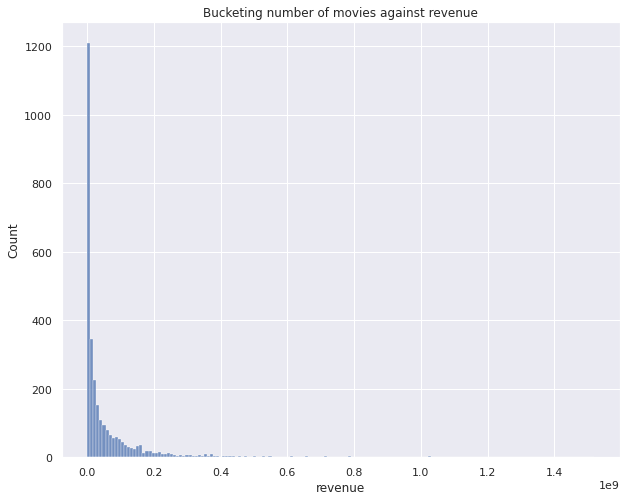

In [ ]:
plt.subplots(figsize=[10,8])
ax = sns.histplot(data=train_df['revenue'])
ax.set_title('Bucketing number of movies against revenue')
plt.show()

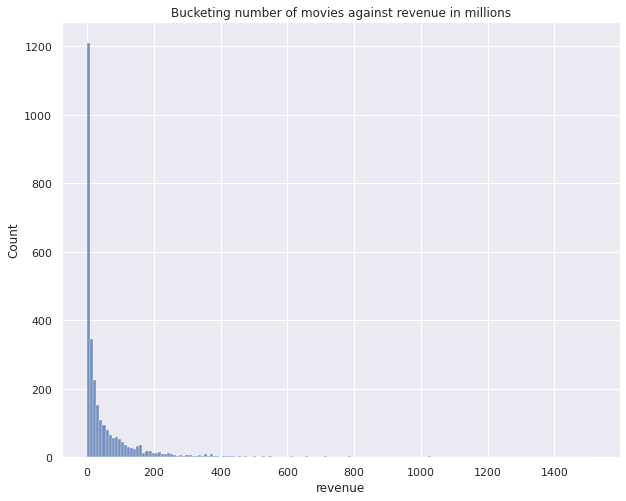

In [ ]:
plt.subplots(figsize=[10,8])
ax = sns.histplot(data=train_df['revenue']/1000000)
ax.set_title('Bucketing number of movies against revenue in millions')
plt.show()

Since, the revenue is pretty skewed, I want to take a closer look so I will plot it again with revenue being with a range.

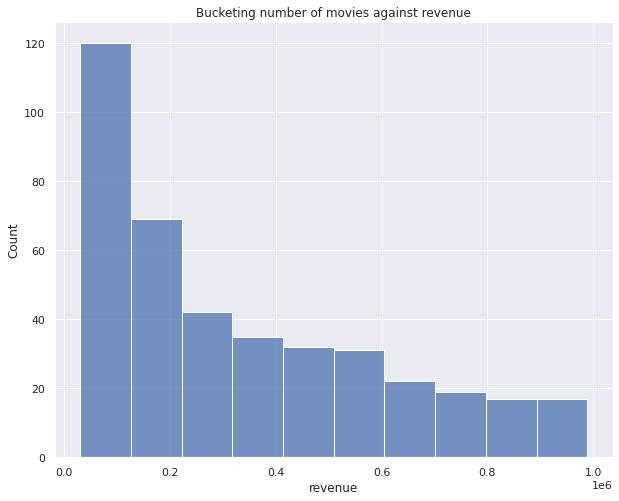

In [ ]:
plt.subplots(figsize=[10,8])
ax = sns.histplot(data=train_df[(train_df['revenue'] > 30000) & (train_df['revenue'] < 1000000)]['revenue'])
ax.set_title('Bucketing number of movies against revenue')
plt.show()

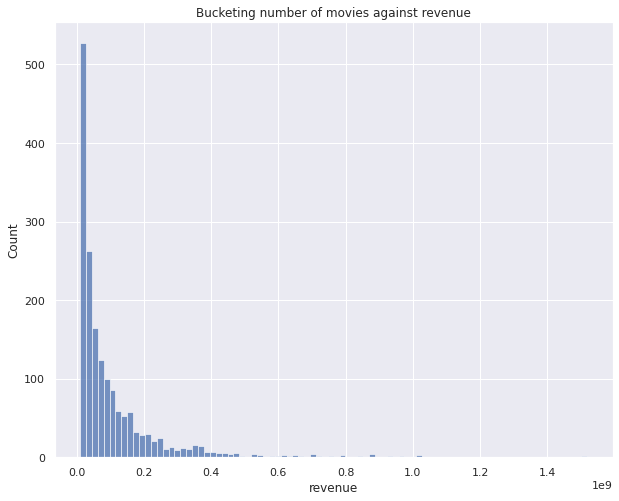

In [ ]:
plt.subplots(figsize=[10,8])
ax = sns.histplot(data=train_df[train_df['revenue'] > 10000000]['revenue'])
ax.set_title('Bucketing number of movies against revenue')
plt.show()

I think we should take the log of revenue to get an overall picture.

In [ ]:
train_df['log_revenue'] = np.log(train_df['revenue'])

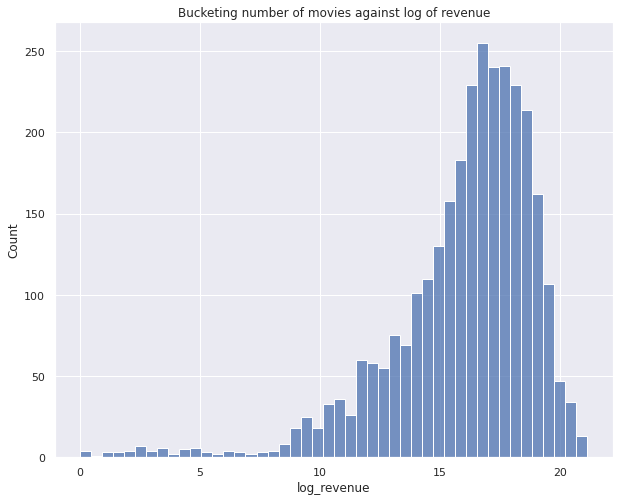

In [ ]:
plt.subplots(figsize=[10,8])
ax = sns.histplot(data=train_df['log_revenue'])
ax.set_title('Bucketing number of movies against log of revenue')
plt.show()

This gives a better picture of the log-revenue distribution that has a long left tail and kind of a small tail (if we may call it so) on the right end too stating there might be a few movies with very high revenue.

## Test data

In [ ]:
test_df.head()

id  ...                                               crew
0  3001  ...  [{'credit_id': '52fe44e7c3a368484e03d683', 'de...
1  3002  ...  [{'credit_id': '55807805c3a3685b1300060b', 'de...
2  3003  ...  [{'credit_id': '52fe4330c3a36847f8041367', 'de...
3  3004  ...  [{'credit_id': '56478092c3a36826140043af', 'de...
4  3005  ...  [{'credit_id': '52fe44ce9251416c75041967', 'de...

[5 rows x 22 columns]

In [ ]:
test_df.columns

Index(['id', 'belongs_to_collection', 'budget', 'genres', 'homepage',
       'imdb_id', 'original_language', 'original_title', 'overview',
       'popularity', 'poster_path', 'production_companies',
       'production_countries', 'release_date', 'runtime', 'spoken_languages',
       'status', 'tagline', 'title', 'Keywords', 'cast', 'crew'],
      dtype='object')

In [ ]:
(test_df.isnull()).sum()

id                          0
belongs_to_collection    3521
budget                      0
genres                     16
homepage                 2978
imdb_id                     0
original_language           0
original_title              0
overview                   14
popularity                  0
poster_path                 1
production_companies      258
production_countries      102
release_date                1
runtime                     4
spoken_languages           42
status                      2
tagline                   863
title                       3
Keywords                  393
cast                       13
crew                       22
dtype: int64

#### Dealing with Missing Data

###### Filling in missing values where possible

I am going to convert the 'homepage' and 'tagline' columns into boolean columns 'has_homepage' and 'has_tagline' respectively, as done for the train data.

In [ ]:
test_df['has_homepage'] = pd.notnull(test_df['homepage'])
test_df['has_tagline'] = pd.notnull(test_df['tagline'])
test_df = test_df.drop(columns=['homepage', 'tagline'])

In [ ]:
(test_df.isnull()).sum()

id                          0
belongs_to_collection    3521
budget                      0
genres                     16
imdb_id                     0
original_language           0
original_title              0
overview                   14
popularity                  0
poster_path                 1
production_companies      258
production_countries      102
release_date                1
runtime                     4
spoken_languages           42
status                      2
title                       3
Keywords                  393
cast                       13
crew                       22
has_homepage                0
has_tagline                 0
dtype: int64

Dropping the 'poster_path' column as in train data.

In [ ]:
test_df = test_df.drop(columns=['poster_path'])

There are 4 rows having null in the 'runtime' column, I will fill in those by looking for sources online.

In [ ]:
test_df[pd.isnull(test_df['runtime'])]

id belongs_to_collection  ...  has_homepage has_tagline
243   3244                   NaN  ...         False       False
1489  4490                   NaN  ...         False       False
1632  4633                   NaN  ...         False       False
3817  6818                   NaN  ...         False       False

[4 rows x 21 columns]

https://www.imdb.com/title/tt0082131/  id-3244 (93min)

https://es.wikipedia.org/wiki/Pancho,_el_perro_millonario id-4490 (90min)

https://www.imdb.com/title/tt0078010/technical?ref_=tt_dt_spec  id-4633 (100min)

https://www.imdb.com/title/tt2192844/ id-6618 (90min)


I could find the runtimes in the above links, so I will update the same.

In [ ]:
test_df.loc[243, 'runtime'] = 93.0
test_df.loc[1489, 'runtime'] = 90.0
test_df.loc[1632, 'runtime'] = 100.0
test_df.loc[3817, 'runtime'] = 90.0

In [ ]:
test_df[test_df.original_title=='La caliente niña Julietta']

id belongs_to_collection  ...  has_homepage has_tagline
243  3244                   NaN  ...         False       False

[1 rows x 21 columns]

In [ ]:
test_df[test_df.original_title=='Pancho, el perro millonario']

id belongs_to_collection  ...  has_homepage has_tagline
1489  4490                   NaN  ...         False       False

[1 rows x 21 columns]

In [ ]:
test_df[test_df.original_title=='Nunca en horas de clase']

id belongs_to_collection  ...  has_homepage has_tagline
1632  4633                   NaN  ...         False       False

[1 rows x 21 columns]

In [ ]:
test_df[test_df.original_title=='Miesten välisiä keskusteluja']

id belongs_to_collection  ...  has_homepage has_tagline
3817  6818                   NaN  ...         False       False

[1 rows x 21 columns]

In [ ]:
(test_df.isnull()).sum()

id                          0
belongs_to_collection    3521
budget                      0
genres                     16
imdb_id                     0
original_language           0
original_title              0
overview                   14
popularity                  0
production_companies      258
production_countries      102
release_date                1
runtime                     0
spoken_languages           42
status                      2
title                       3
Keywords                  393
cast                       13
crew                       22
has_homepage                0
has_tagline                 0
dtype: int64

There is 1 row having null in the 'release_data' column, I will fill in that by looking for sources online.

In [ ]:
test_df[pd.isnull(test_df['release_date'])]

id belongs_to_collection  budget  ... crew has_homepage has_tagline
828  3829                   NaN       0  ...  NaN        False        True

[1 rows x 21 columns]

https://www.imdb.com/title/tt0210130/ shows the release date as May 2000 at a film festival, but shows the opening weekend sale to be reported on 21st Oct, 2001.
I'll fill in with 19th Oct 2001, i.e., '10/19/01'

In [ ]:
test_df.loc[828, 'release_date'] = '10/19/01'

In [ ]:
test_df.loc[[828]]

id belongs_to_collection  budget  ... crew has_homepage has_tagline
828  3829                   NaN       0  ...  NaN        False        True

[1 rows x 21 columns]

Now, we have the following columns with missing values:

1. belongs_to_collection -- I would treat this as is_collection_part boolean and also do some analysis based on collection names later. So, I don't need to fill in these values because not all movies need to be a part of a collection.

2. overview 

3. production_companies

4. production_countries

5. spoken_languages

6. Keywords

7. cast

8. crew

9. title

10. status

-- There are missing values here, for now I am going to leave them as is like I did for train data.

Though, similaar to train data, I will create a boolean coulmn 'is_collection_part' to denote if the movie belongs to a collection or not. 

In [ ]:
test_df['is_collection_part'] = pd.notnull(test_df['belongs_to_collection'])

In [ ]:
test_df.head()

id  ... is_collection_part
0  3001  ...               True
1  3002  ...              False
2  3003  ...              False
3  3004  ...              False
4  3005  ...              False

[5 rows x 22 columns]

##### Converting strings to lists where columns have lists of dicts as strings

Now, I have to tackle the issue of the format of the few columns that are a string of list of dicts. So, I will convert these columns into lists of dicts for ease of access and computation. I will replace the null values with empty lists at the same time.

In [ ]:
test_df['belongs_to_collection'] = test_df['belongs_to_collection'].apply(lambda x : [] if pd.isna(x) else eval(x))
test_df['genres'] = test_df['genres'].apply(lambda x : [] if pd.isna(x) else eval(x))
test_df['production_companies'] = test_df['production_companies'].apply(lambda x : [] if pd.isna(x) else eval(x))
test_df['production_countries'] = test_df['production_countries'].apply(lambda x : [] if pd.isna(x) else eval(x))
test_df['spoken_languages'] = test_df['spoken_languages'].apply(lambda x : [] if pd.isna(x) else eval(x))
test_df['Keywords'] = test_df['Keywords'].apply(lambda x : [] if pd.isna(x) else eval(x))
test_df['cast'] = test_df['cast'].apply(lambda x : [] if pd.isna(x) else eval(x))
test_df['crew'] = test_df['crew'].apply(lambda x : [] if pd.isna(x) else eval(x))

In [ ]:
(test_df.isnull()).sum()

id                        0
belongs_to_collection     0
budget                    0
genres                    0
imdb_id                   0
original_language         0
original_title            0
overview                 14
popularity                0
production_companies      0
production_countries      0
release_date              0
runtime                   0
spoken_languages          0
status                    2
title                     3
Keywords                  0
cast                      0
crew                      0
has_homepage              0
has_tagline               0
is_collection_part        0
dtype: int64

#### Dealing with Anomalous Data

In [ ]:
test_df.columns

Index(['id', 'belongs_to_collection', 'budget', 'genres', 'imdb_id',
       'original_language', 'original_title', 'overview', 'popularity',
       'production_companies', 'production_countries', 'release_date',
       'runtime', 'spoken_languages', 'status', 'title', 'Keywords', 'cast',
       'crew', 'has_homepage', 'has_tagline', 'is_collection_part'],
      dtype='object')

All the column names seem to be self-explanatory except 'status'. I want to check the values in the 'status' column.

In [ ]:
test_df['status'].unique()

array(['Released', 'Rumored', 'Post Production', nan], dtype=object)

In [ ]:
test_df[test_df['status']=='Rumored']

id  ... is_collection_part
102   3103  ...              False
1477  4478  ...               True

[2 rows x 22 columns]

In [ ]:
test_df[test_df['status']=='Post Production']

id belongs_to_collection  ...  has_tagline is_collection_part
264   3265                    []  ...         True              False
847   3848                    []  ...        False              False
1260  4261                    []  ...         True              False
1448  4449                    []  ...         True              False
2585  5586                    []  ...        False              False

[5 rows x 22 columns]

In [ ]:
test_df[pd.isnull(test_df['status'])]

id belongs_to_collection  ...  has_tagline is_collection_part
828   3829                    []  ...         True              False
1056  4057                    []  ...        False              False

[2 rows x 22 columns]

Since all of these have release dates, I will treat them as released movies, and if more information is required I will deal with it later during prediction.

# Part 2 - Word Cloud

## Genres

In [ ]:
wordcloud_genres = WordCloud().generate(' '.join(genres_df['name']))

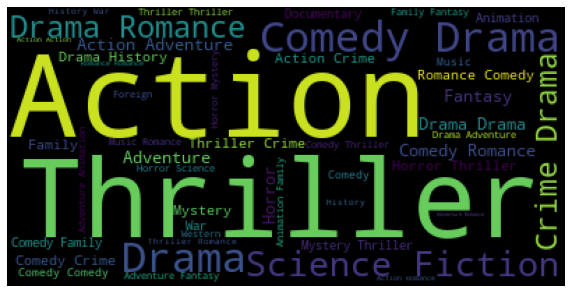

In [ ]:
# plt.figure(figsize = (12, 10))
plt.imshow(wordcloud_genres)
plt.axis("off")
# plt.tight_layout(pad = 0) 

plt.show()

Looks like there are a lot of movies under the genres of Action and Thriller. I see some domination by Drama, Crime and Comedy, Romance and Science too. We will verify this later when I explore some plots.

## Keyword

In [ ]:
wordcloud_keywords = WordCloud().generate(' '.join(keywords_df['name']))

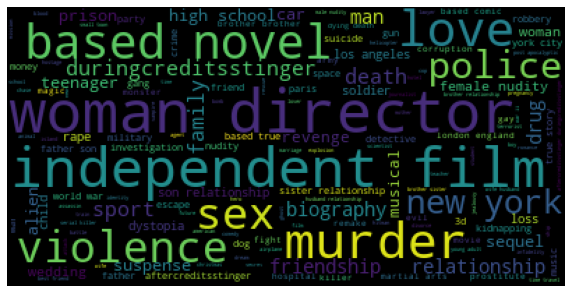

In [ ]:
# plt.figure(figsize = (12, 10))
plt.imshow(wordcloud_keywords)
plt.axis("off")
# plt.tight_layout(pad = 0) 

plt.show()

Looks like many movies are based on novels, murder, violence, love, women, police, sex. And many independent films are there.

## Original_titles

In [ ]:
wordcloud_otitles = WordCloud().generate(' '.join(train_df['original_title']))

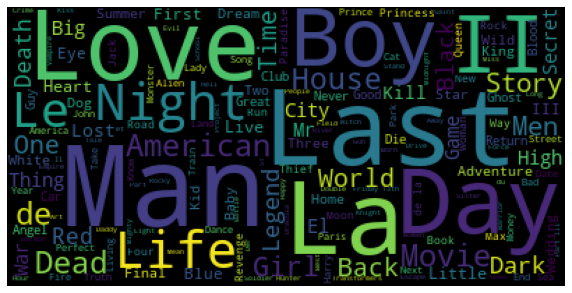

In [ ]:
# plt.figure(figsize = (12, 10))
plt.imshow(wordcloud_otitles)
plt.axis("off")
# plt.tight_layout(pad = 0) 

plt.show()

It seems many movies have words like 'love', 'man', 'life', 'last', 'day', 'boy' in them. Also, I'm guessing there may be quite a few sequels because there is a domination seen by 'II'.

## Overview

In [ ]:
wordcloud_overview = WordCloud().generate(' '.join(train_df[train_df['overview'].notnull()]['overview']))

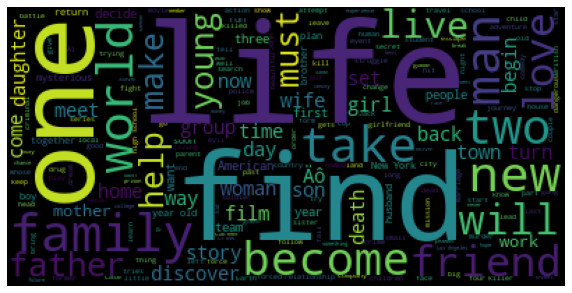

In [ ]:
# plt.figure(figsize = (12, 10))
plt.imshow(wordcloud_overview)
plt.axis("off")
# plt.tight_layout(pad = 0) 

plt.show()

Again, 'life' stands out along with 'find', 'one', 'world', 'family', 'friend', 'love'. Looks like many movies are focussed on life, family, friendship, love and world.

# Part 3 - Time Series Analysis

### Converting to datetime

In [ ]:
type(train_df['release_date'][0])

str

In [ ]:
train_df['release_date'][0]

'2/20/15'

Since the year is in yy format, converting the date string directly to datetime gave me absurd results with movies having release dates in 2088!! That made me realize I need to convert the date string so as pandas can appropriately understand the correct century! 

In [ ]:
def correctCentury(date):
  year = date.split('/')[2]

  if int(year) <=20:
    return date[:-2] + '20' + year
  else:
    return date[:-2] + '19' + year

train_df['release_date'] = train_df['release_date'].apply(lambda x : correctCentury(x))

In [ ]:
train_df['release_date'] = pd.to_datetime(train_df['release_date'])

In [ ]:
train_df.head(1)

id  ... log_revenue
0   1  ...      16.326

[1 rows x 24 columns]

In [ ]:
train_df['release_date'][0].month

2

### Adding required columns

In [ ]:
train_df['day_of_week'] = train_df['release_date'].dt.day_name()
train_df['month'] = train_df['release_date'].dt.month_name()
train_df['year'] = train_df['release_date'].dt.year

In [ ]:
train_df.head()

id                              belongs_to_collection  ...     month  year
0   1  [{'id': 313576, 'name': 'Hot Tub Time Machine ...  ...  February  2015
1   2  [{'id': 107674, 'name': 'The Princess Diaries ...  ...    August  2004
2   3                                                 []  ...   October  2014
3   4                                                 []  ...     March  2012
4   5                                                 []  ...  February  2009

[5 rows x 27 columns]

Write your answer here

### Visualizing time series data

#### Monthly

Plotting number of movies released by month of year

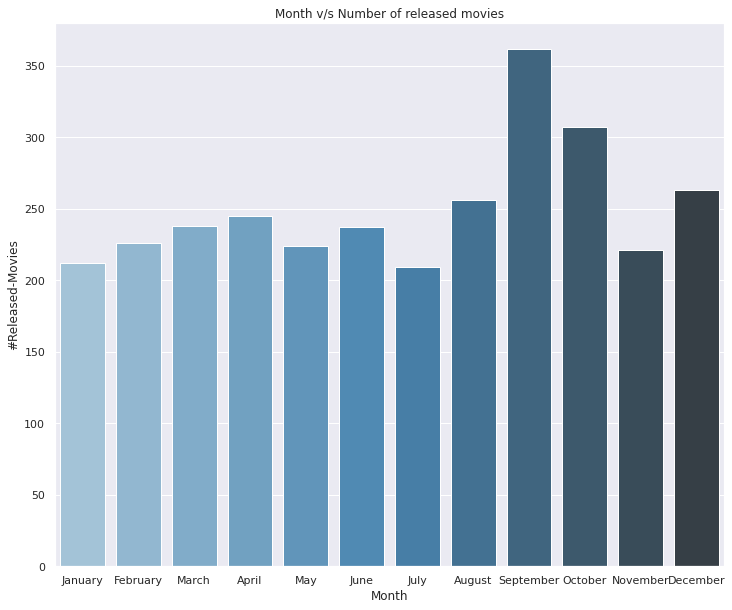

In [ ]:
monthly_groupby = train_df.groupby('month', as_index=False)[['id']].count()
plt.subplots(figsize=[12,10])
order = ['January', 'February', 'March', 'April', 'May', 'June', 
             'July', 'August', 'September', 'October', 'November', 'December']
plot = sns.barplot(x='month', y='id', data=monthly_groupby.sort_values('month', ascending=False), palette='Blues_d', order=order)
plot.set_title('Month v/s Number of released movies');
plot.set(xlabel='Month', ylabel='#Released-Movies')
plt.show()

Looks like the months of September and October usually see a lot of movie releases. But then, since the data ranges over a lot of years, we can't outright say that for every year we see a lot of movies in Sep and Oct -- it is possible that a few years might have seen a surge in movie releases in those 2 months that gives us that spike; and it is also possible that, that is a general trend of movie releases for those 2 months.

#### Weekly

Plot #Released-Movies by day of week

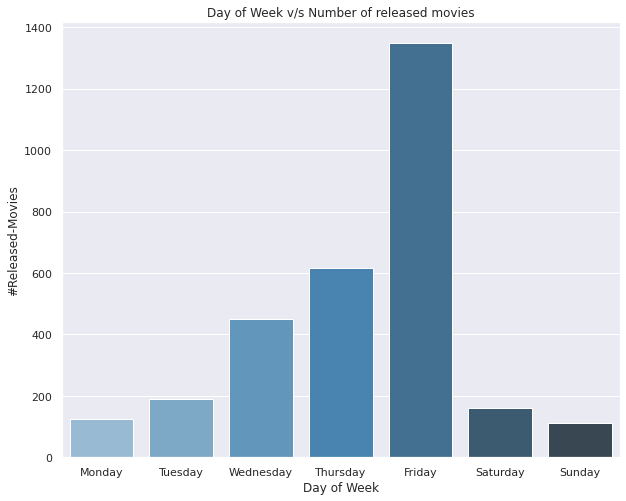

In [ ]:
weekly_groupby = train_df.groupby('day_of_week', as_index=False)[['id']].count()
plt.subplots(figsize=[10,8])
order = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
plot = sns.barplot(x='day_of_week', y='id', data=weekly_groupby, palette='Blues_d', order=order)
plot.set_title('Day of Week v/s Number of released movies');
plot.set(xlabel='Day of Week', ylabel='#Released-Movies')
plt.show()

This kind of seems expected. Because, by the world knowledge, we do know that most of the movies release on a friday owing to the upcoming weekend. And we see the same trend here with a huge spike for friday.

#### Yearly

Plot #Released-Movies by year

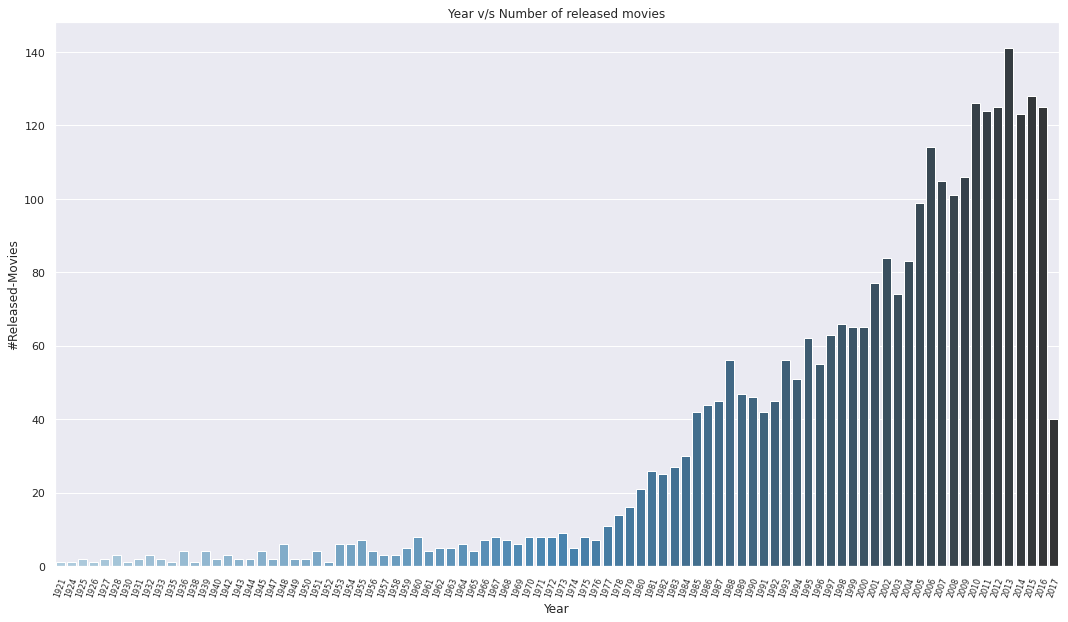

In [ ]:
yearly_groupby = train_df.groupby('year', as_index=False)[['id']].count()
plt.subplots(figsize=[18,10])
plot = sns.barplot(x='year', y='id', data=yearly_groupby, palette='Blues_d')
plot.set_title('Year v/s Number of released movies');
plot.set(xlabel='Year', ylabel='#Released-Movies')
plot.set_xticklabels(plot.get_xticklabels(), fontsize=8)
plt.xticks(rotation=70)

plt.show()

Looks like there were far less movies that were made or at least released for almost 6 decades from 1921. Things slowly started picking up after that with a fair number of movies being released which only went up as a general trend from year to year with minor fluctuations. The year of 2013 recorded the maximum number of movies released. We see a dip in 2017, assumably because of lack of data beyond a certain time in 2017.

This also tells us that people in general started a liking towards movies over the years and the movie-making business boomed.

# Part 3 - Time Series Analysis - Test


### Converting to datetime

In [ ]:
test_df.head(1)

id  ... is_collection_part
0  3001  ...               True

[1 rows x 22 columns]

In [ ]:
test_df['release_date'] = test_df['release_date'].apply(lambda x : correctCentury(x))

In [ ]:
test_df['release_date'] = pd.to_datetime(test_df['release_date'])

In [ ]:
test_df.head(1)

id  ... is_collection_part
0  3001  ...               True

[1 rows x 22 columns]

In [ ]:
test_df['release_date'][0].day

14

### Adding required columns

In [ ]:
test_df['day_of_week'] = test_df['release_date'].dt.day_name()
test_df['month'] = test_df['release_date'].dt.month_name()
test_df['year'] = test_df['release_date'].dt.year

In [ ]:
test_df.head()

id                              belongs_to_collection  ...      month  year
0  3001  [{'id': 34055, 'name': 'Pokémon Collection', '...  ...       July  2007
1  3002                                                 []  ...        May  1958
2  3003                                                 []  ...        May  1997
3  3004                                                 []  ...  September  2010
4  3005                                                 []  ...   February  2005

[5 rows x 25 columns]

Write your answer here

### Visualizing time series data

#### Monthly

Plotting number of movies released by month of year

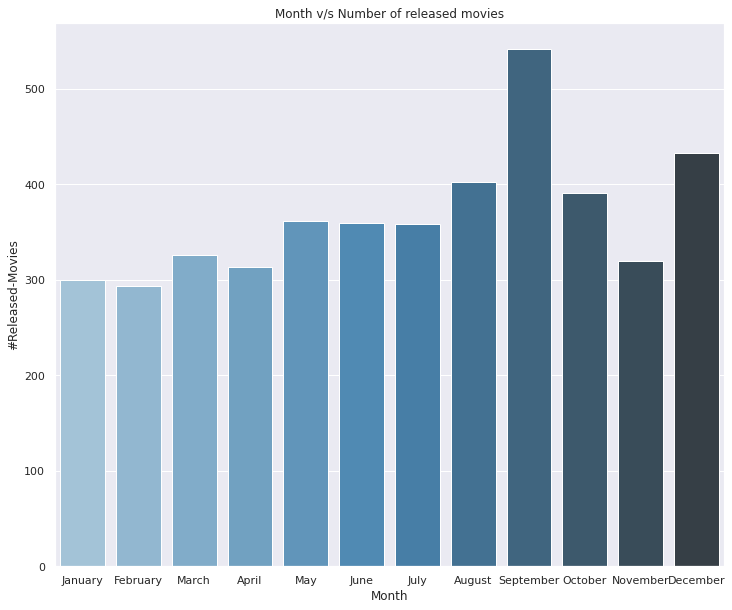

In [ ]:
monthly_groupby_test = test_df.groupby('month', as_index=False)[['id']].count()
plt.subplots(figsize=[12,10])
order = ['January', 'February', 'March', 'April', 'May', 'June', 
             'July', 'August', 'September', 'October', 'November', 'December']
plot = sns.barplot(x='month', y='id', data=monthly_groupby_test.sort_values('month', ascending=False), palette='Blues_d', order=order)
plot.set_title('Month v/s Number of released movies');
plot.set(xlabel='Month', ylabel='#Released-Movies')
plt.show()

#### Weekly

Plot #Released-Movies by day of week

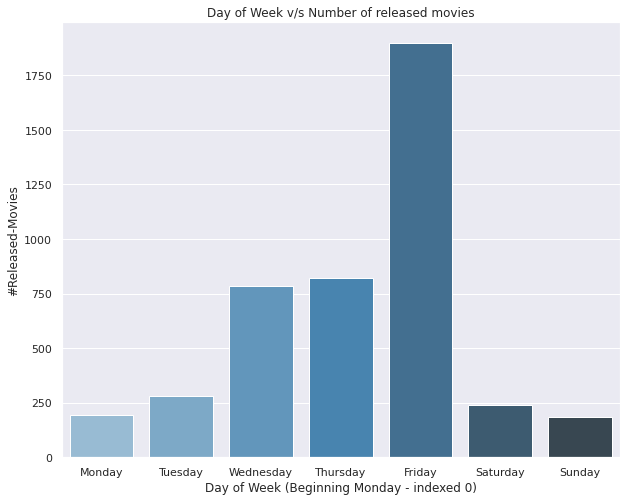

In [ ]:
weekly_groupby_test = test_df.groupby('day_of_week', as_index=False)[['id']].count()
plt.subplots(figsize=[10,8])
order = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
plot = sns.barplot(x='day_of_week', y='id', data=weekly_groupby_test, palette='Blues_d', order=order)
plot.set_title('Day of Week v/s Number of released movies');
plot.set(xlabel='Day of Week (Beginning Monday - indexed 0)', ylabel='#Released-Movies')
plt.show()

#### Yearly

Plot #Released-Movies by year

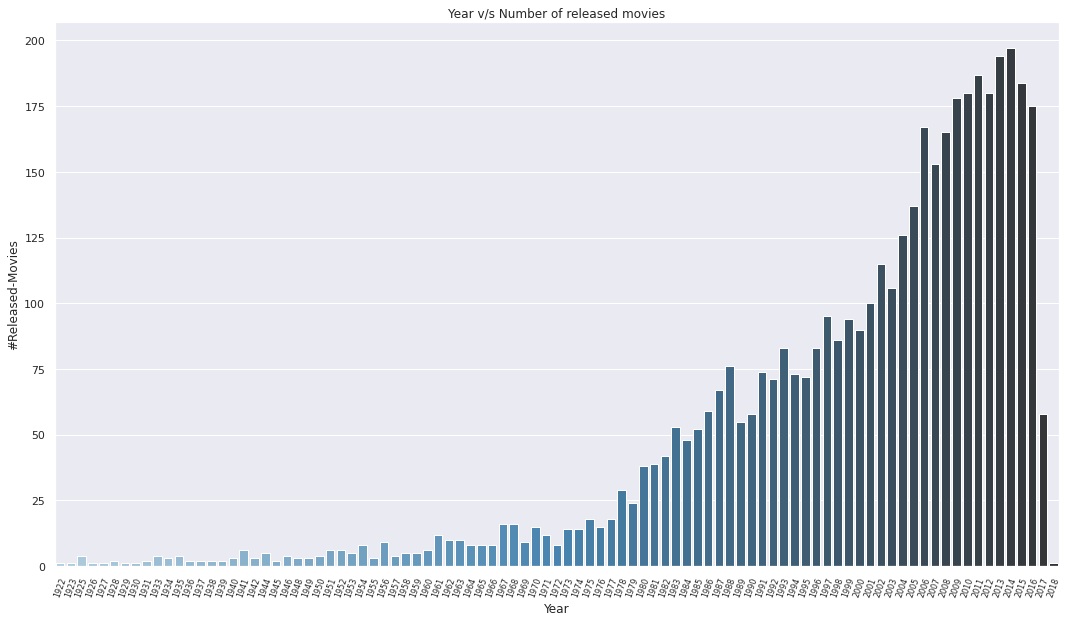

In [ ]:
yearly_groupby_test = test_df.groupby('year', as_index=False)[['id']].count()
plt.subplots(figsize=[18,10])
plot = sns.barplot(x='year', y='id', data=yearly_groupby_test, palette='Blues_d')
plot.set_title('Year v/s Number of released movies');
plot.set(xlabel='Year', ylabel='#Released-Movies')
plot.set_xticklabels(plot.get_xticklabels(), fontsize=8)
plt.xticks(rotation=70)

plt.show()

## Observations

We see a very similar trend/pattern in the test data as well, which might be an aid in predicting the revenues.

# Part 4 - Cast Power

###Finding the details available in cast column

In [ ]:
cast_3 = train_df['cast'][3]

In [ ]:
cast_3

[{'cast_id': 1,
  'character': 'Vidya Bagchi',
  'credit_id': '52fe48779251416c9108d6d9',
  'gender': 1,
  'id': 35068,
  'name': 'Vidya Balan',
  'order': 0,
  'profile_path': '/anMmmqKY11jcm0UnSSakfNOSCyB.jpg'},
 {'cast_id': 5,
  'character': '',
  'credit_id': '57722abec3a368245b004519',
  'gender': 2,
  'id': 85047,
  'name': 'Nawazuddin Siddiqui',
  'order': 1,
  'profile_path': '/2Kv2ENAs1ETAFTQ6mC1jbDzEzIN.jpg'},
 {'cast_id': 6,
  'character': '',
  'credit_id': '57722aea9251411dca003f8f',
  'gender': 0,
  'id': 1021524,
  'name': 'Parambrata Chatterjee',
  'order': 2,
  'profile_path': '/Aif4X9ihmRrVzX1cbWDDznk8HZV.jpg'},
 {'cast_id': 7,
  'character': '',
  'credit_id': '57722b069251411dcd003f73',
  'gender': 0,
  'id': 1093644,
  'name': 'Saswata Chatterjee',
  'order': 3,
  'profile_path': '/vuHaLzSVRIo7pXSmhB7ko6YmNs.jpg'},
 {'cast_id': 8,
  'character': '',
  'credit_id': '57722b26c3a36869a2000745',
  'gender': 0,
  'id': 86033,
  'name': 'Indraneil Sengupta',
  'order': 4

## Basic Features

### Adding new (basic) features to demonstrate cast power

I will add cast count, and gender counts of the cast.

In [ ]:
train_df['cast_count'] = train_df['cast'].apply(lambda x : len([cast['cast_id'] for cast in x]))

In [ ]:
train_df['gender_dict'] = train_df['cast'].apply(lambda x : dict(Counter([cast['gender'] for cast in x])))
train_df = pd.concat([train_df.drop(['gender_dict'], axis=1), train_df['gender_dict'].apply(pd.Series)], axis=1)
train_df.rename(columns={0:'na_gender_cast_count', 1: 'female_cast_count', 2: 'male_cast_count'}, inplace=True)

In [ ]:
train_df.isnull().sum()

id                         0
belongs_to_collection      0
budget                     0
genres                     0
imdb_id                    0
original_language          0
original_title             0
overview                   8
popularity                 0
production_companies       0
production_countries       0
release_date               0
runtime                    0
spoken_languages           0
status                     0
title                      0
Keywords                   0
cast                       0
crew                       0
revenue                    0
has_homepage               0
has_tagline                0
is_collection_part         0
log_revenue                0
day_of_week                0
month                      0
year                       0
cast_count                 0
na_gender_cast_count     365
female_cast_count        237
male_cast_count           94
dtype: int64

In [ ]:
train_df['na_gender_cast_count'].fillna(0, inplace=True)
train_df['female_cast_count'].fillna(0, inplace=True)
train_df['male_cast_count'].fillna(0, inplace=True)

In [ ]:
train_df.isnull().sum()

id                       0
belongs_to_collection    0
budget                   0
genres                   0
imdb_id                  0
original_language        0
original_title           0
overview                 8
popularity               0
production_companies     0
production_countries     0
release_date             0
runtime                  0
spoken_languages         0
status                   0
title                    0
Keywords                 0
cast                     0
crew                     0
revenue                  0
has_homepage             0
has_tagline              0
is_collection_part       0
log_revenue              0
day_of_week              0
month                    0
year                     0
cast_count               0
na_gender_cast_count     0
female_cast_count        0
male_cast_count          0
dtype: int64

In [ ]:
train_df.head()

id  ... male_cast_count
0   1  ...          10.000
1   2  ...          10.000
2   3  ...          13.000
3   4  ...           2.000
4   5  ...           4.000

[5 rows x 31 columns]

### Visualizing cast counts against revenue

In [ ]:
train_df.columns

Index(['id', 'belongs_to_collection', 'budget', 'genres', 'imdb_id',
       'original_language', 'original_title', 'overview', 'popularity',
       'production_companies', 'production_countries', 'release_date',
       'runtime', 'spoken_languages', 'status', 'title', 'Keywords', 'cast',
       'crew', 'revenue', 'has_homepage', 'has_tagline', 'is_collection_part',
       'log_revenue', 'day_of_week', 'month', 'year', 'cast_count',
       'na_gender_cast_count', 'female_cast_count', 'male_cast_count'],
      dtype='object')

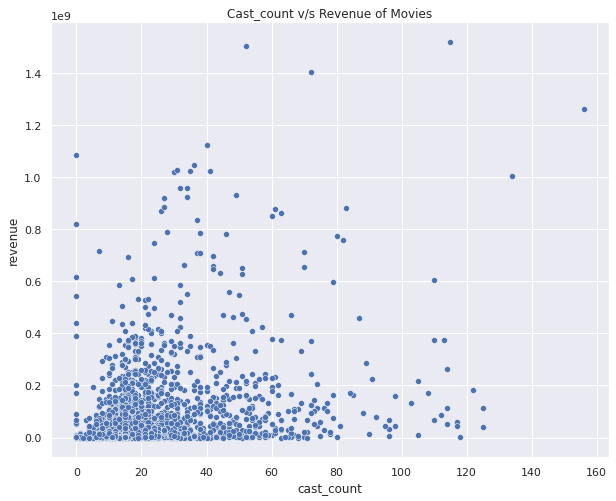

In [ ]:
plt.subplots(figsize=[10,8])
ax = sns.scatterplot(x='cast_count', y='revenue', data=train_df)
ax.set_title('Cast_count v/s Revenue of Movies')
plt.show()

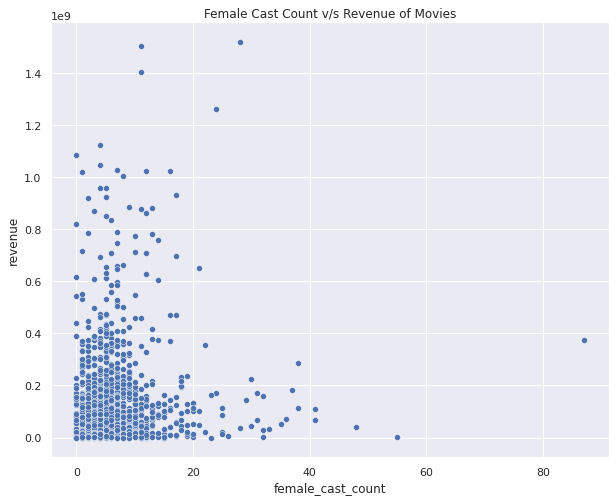

In [ ]:
plt.subplots(figsize=[10,8])
ax = sns.scatterplot(x='female_cast_count', y='revenue', data=train_df)
ax.set_title('Female Cast Count v/s Revenue of Movies')
plt.show()

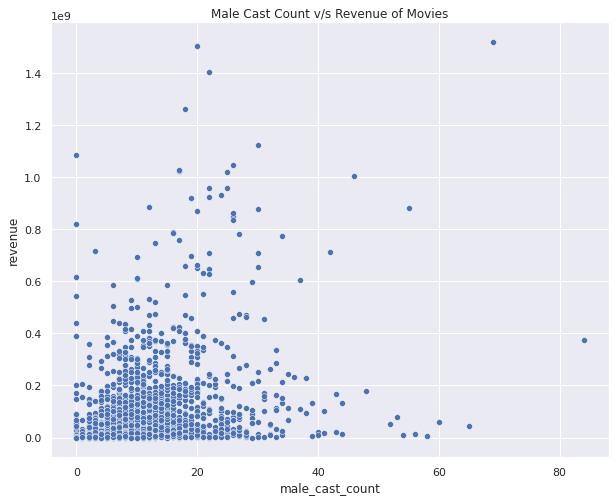

In [ ]:
plt.subplots(figsize=[10,8])
ax = sns.scatterplot(x='male_cast_count', y='revenue', data=train_df)
ax.set_title('Male Cast Count v/s Revenue of Movies')
plt.show()

## Advanced Features

### Advanced-Count-Based Cast Power

In [ ]:
cast_df.head()

cast_id          character  ... order                      profile_path
0        4                Lou  ...     0  /k2zJL0V1nEZuFT08xUdOd3ucfXz.jpg
1        5               Nick  ...     1  /tVaRMkJXOEVhYxtnnFuhqW0Rjzz.jpg
2        6              Jacob  ...     2  /oNzK0umwm5Wn0wyEbOy6TVJCSBn.jpg
3        7           Adam Jr.  ...     3  /5gb65xz8bzd42yjMAl4zwo4cvKw.jpg
4        8  Hot Tub Repairman  ...     4  /svjpyYtPwtjvRxX9IZnOmOkhDOt.jpg

[5 rows x 8 columns]

In [ ]:
cast_df.isnull().sum()

cast_id             0
character           0
credit_id           0
gender              0
id                  0
name                0
order               0
profile_path    14917
dtype: int64

#### Frequency-Based Feature

1. Calculate actor-freq as the #movies an actor appears in.
2. For each movie, add up the actor-freq of each actor in the cast.

In [ ]:
cast_frequency = cast_df.groupby('id', as_index=False).agg({'name': 'last', 'cast_id': 'count'})
cast_frequency.rename(columns={'cast_id': 'actor_freq'}, inplace=True)

In [ ]:
cast_frequency.sort_values('actor_freq', ascending=False).head(10)

id               name  actor_freq
843    2231  Samuel L. Jackson          30
136     380     Robert De Niro          30
65      192     Morgan Freeman          27
1487   4038     Susan Sarandon          25
30       62       Bruce Willis          25
1441   3896        Liam Neeson          25
5127  18999       J.K. Simmons          25
490    1241      John Turturro          24
4214  14888       Bruce McGill          24
1831   5293       Willem Dafoe          23

In [ ]:
def calculateFreqCastPower(cast):
  return sum([int(cast_frequency[cast_frequency.id == x['id']]['actor_freq']) for x in cast])


In [ ]:
train_df['freq_cast_power'] = train_df['cast'].apply(lambda x : calculateFreqCastPower(x))

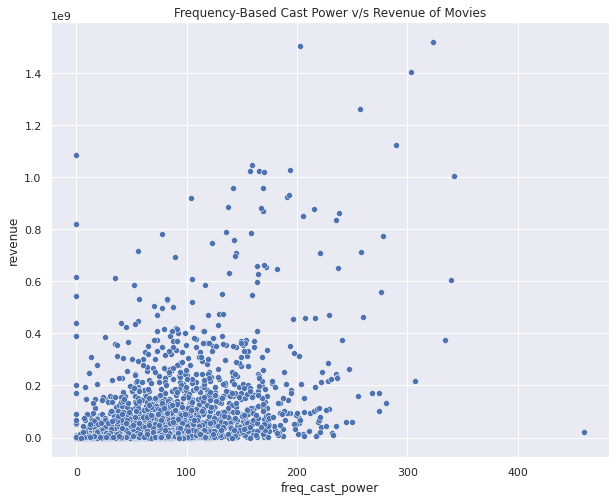

In [ ]:
plt.subplots(figsize=[10,8])
ax = sns.scatterplot(x='freq_cast_power', y='revenue', data=train_df)
ax.set_title('Frequency-Based Cast Power v/s Revenue of Movies')
plt.show()

#### Average-Frequency-Based Feature

The only difference from Frequency-Based Cast power would be that we will take the average of actor_freq's of actors in a movie instead of the sum.

In [ ]:
def calculateAvgFreqCastPower(cast):
  return statistics.mean([int(cast_frequency[cast_frequency.id == x['id']]['actor_freq']) for x in cast])


In [ ]:
train_df['avg_freq_cast_power'] = train_df['cast'].apply(lambda x : 0 if not x else calculateAvgFreqCastPower(x))

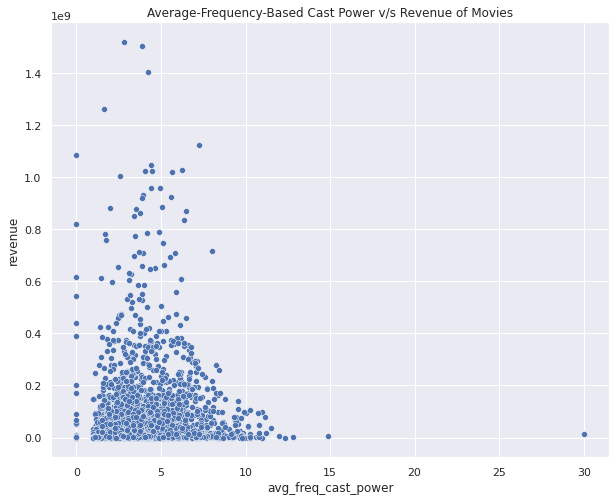

In [ ]:
plt.subplots(figsize=[10,8])
ax = sns.scatterplot(x='avg_freq_cast_power', y='revenue', data=train_df)
ax.set_title('Average-Frequency-Based Cast Power v/s Revenue of Movies')
plt.show()

#### Lead-Frequency-Based Feature (1st 2 Leads)

I will consider an actor to be in a leading role if their order number is either 0 or 1.

Considering this, I will repeat the frequency-based cast power but this time only counting the frequency when the actor was in a leading role.

In [ ]:
cast_lead_frequency = cast_df.groupby(['id', 'order'], as_index=False).agg({'name': 'last', 'cast_id': 'count'})
cast_lead_frequency.rename(columns={'cast_id': 'actor_lead_freq'}, inplace=True)

In [ ]:
cast_lead_frequency.sort_values(['actor_lead_freq'], ascending=False).head(10)

id  order                name  actor_lead_freq
5219    5292      0   Denzel Washington               17
11583  16483      0  Sylvester Stallone               16
3428    2963      0        Nicolas Cage               14
10002  13240      0       Mark Wahlberg               14
1788    1461      0      George Clooney               14
2969    2461      0          Mel Gibson               14
529      380      0      Robert De Niro               14
1136     887      0         Owen Wilson               13
161       85      0         Johnny Depp               12
2170    1892      0          Matt Damon               12

In [ ]:
len(cast_lead_frequency)

56755

In [ ]:
cast_lead_frequency = cast_lead_frequency[cast_lead_frequency.order < 2]

In [ ]:
len(cast_lead_frequency)

3637

In [ ]:
cast_lead_frequency.head()

id  order           name  actor_lead_freq
2    2      0    Mark Hamill                1
3    2      1    Mark Hamill                1
6    3      0  Harrison Ford               11
11   4      1  Carrie Fisher                2
18   5      1  Peter Cushing                1

In [ ]:
cast_lead_frequency = cast_lead_frequency.groupby('id', as_index=False).agg({'name': 'last', 'actor_lead_freq': 'count'})

In [ ]:
len(cast_lead_frequency)

3076

In [ ]:
cast_lead_frequency.head()

id           name  actor_lead_freq
0   2    Mark Hamill                2
1   3  Harrison Ford                1
2   4  Carrie Fisher                1
3   5  Peter Cushing                1
4  13  Albert Brooks                1

In [ ]:
def calculateLeadFreqCastPower(cast):
  return sum([0 if cast_lead_frequency[cast_lead_frequency.id == x['id']].empty 
     else int(cast_lead_frequency[cast_lead_frequency.id == x['id']]['actor_lead_freq']) for x in cast])


In [ ]:
train_df['lead_freq_cast_power'] = train_df['cast'].apply(lambda x : calculateLeadFreqCastPower(x))

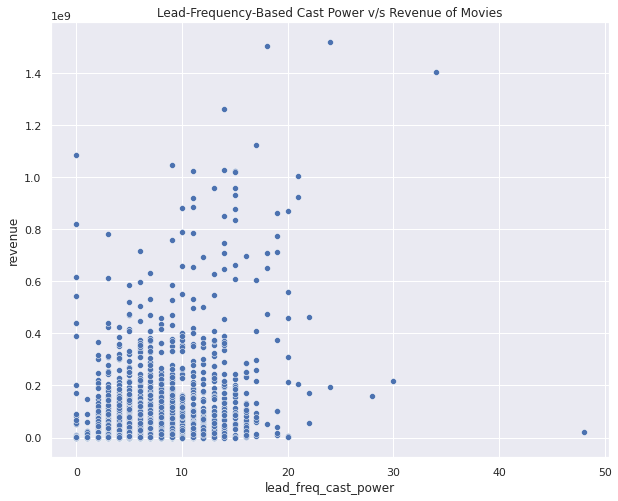

In [ ]:
plt.subplots(figsize=[10,8])
ax = sns.scatterplot(x='lead_freq_cast_power', y='revenue', data=train_df)
ax.set_title('Lead-Frequency-Based Cast Power v/s Revenue of Movies')
plt.show()

#### Lead1-Frequency-Based Feature. (Only 1 Lead)

This time, I will consider an actor to be in a leading role only if their order number is 0.

Considering this, I will repeat the frequency-based cast power but this time only counting the frequency when the actor was in a leading role.

In [ ]:
cast_lead1_frequency = cast_df.groupby(['id', 'order'], as_index=False).agg({'name': 'last', 'cast_id': 'count'})
cast_lead1_frequency.rename(columns={'cast_id': 'actor_lead_freq'}, inplace=True)

In [ ]:
cast_lead1_frequency.sort_values(['actor_lead_freq'], ascending=False).head(10)

id  order                name  actor_lead_freq
5219    5292      0   Denzel Washington               17
11583  16483      0  Sylvester Stallone               16
3428    2963      0        Nicolas Cage               14
10002  13240      0       Mark Wahlberg               14
1788    1461      0      George Clooney               14
2969    2461      0          Mel Gibson               14
529      380      0      Robert De Niro               14
1136     887      0         Owen Wilson               13
161       85      0         Johnny Depp               12
2170    1892      0          Matt Damon               12

In [ ]:
len(cast_lead1_frequency)

56755

In [ ]:
cast_lead1_frequency = cast_lead1_frequency[cast_lead1_frequency.order < 1]

In [ ]:
len(cast_lead1_frequency)

1540

In [ ]:
cast_lead1_frequency.head()

id  order               name  actor_lead_freq
2    2      0        Mark Hamill                1
6    3      0      Harrison Ford               11
36  14      0    Ellen DeGeneres                1
54  20      0  Elizabeth Perkins                1
65  31      0          Tom Hanks               12

In [ ]:
def calculateLead1FreqCastPower(cast):
  return sum([0 if cast_lead1_frequency[cast_lead1_frequency.id == x['id']].empty 
     else int(cast_lead1_frequency[cast_lead1_frequency.id == x['id']]['actor_lead_freq']) for x in cast])


In [ ]:
train_df['lead1_freq_cast_power'] = train_df['cast'].apply(lambda x : calculateLead1FreqCastPower(x))

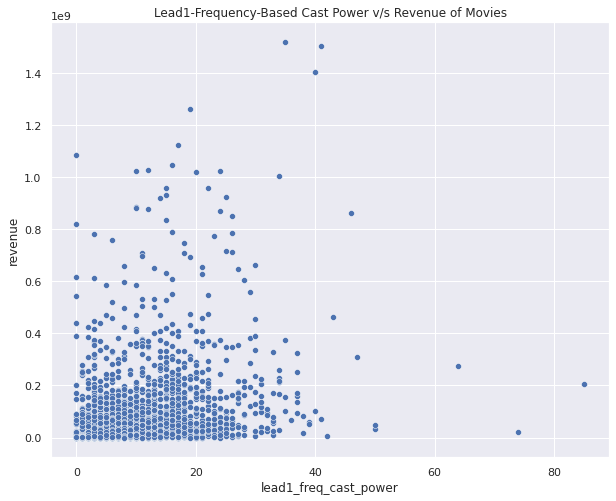

In [ ]:
plt.subplots(figsize=[10,8])
ax = sns.scatterplot(x='lead1_freq_cast_power', y='revenue', data=train_df)
ax.set_title('Lead1-Frequency-Based Cast Power v/s Revenue of Movies')
plt.show()

## Heatmap/Correlation for Count Based Cast Power Features and revenue

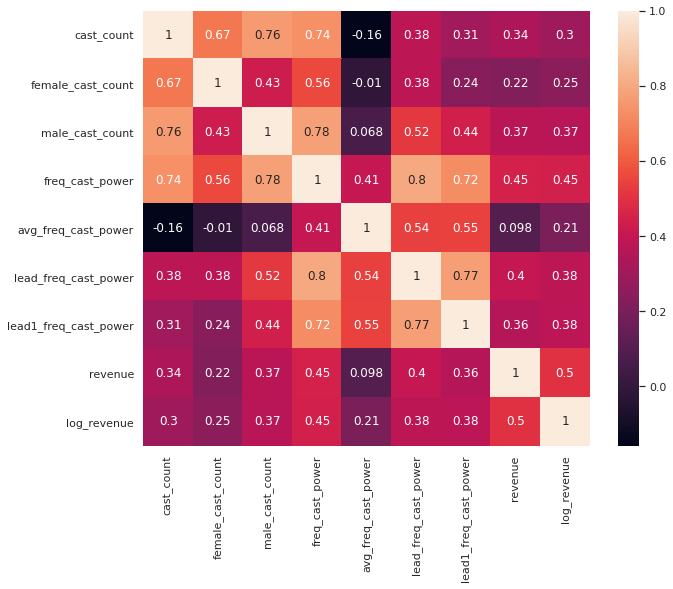

In [ ]:
heatmap1 = train_df[['cast_count', 'female_cast_count', 'male_cast_count', 'freq_cast_power','avg_freq_cast_power', 
                     'lead_freq_cast_power', 'lead1_freq_cast_power', 'revenue', 'log_revenue']]
f,ax = plt.subplots(figsize=(10, 8))
sns.heatmap(heatmap1.corr(), annot=True)
plt.show()

The frequency cast power measure seems to have the highest correlation with revenue among the other cast power measures that I added, with a correlation 0.45. 

The lead frequence cast power (first lead, as well as top 2 leads) also show decent correlation with revenue having a correlation coefficient of 0.36 and 0.4 respectively. With log_revenue both have a correlation of 0.38.

Another interesting thing I notice is that male_cast_count is more correlated with revenue than female cast count -- that seems to bring about a bias that movies with male actors generate more revenue, or it could also be possible that it's just that there are more male actors in more number of movies.

Overall, I think some of these measures might help in predicting revenue.

### Lead-Cast Gender Effect

I was curious about the effect of the gender of the lead.

In [ ]:
def calculateLeadFreqCastPower(cast):
  return sum([0 if cast_lead_frequency[cast_lead_frequency.id == x['id']].empty 
     else int(cast_lead_frequency[cast_lead_frequency.id == x['id']]['actor_lead_freq']) for x in cast])


In [ ]:
train_df['is_lead_male'] = train_df['cast'].apply(lambda x : 0 if not x else 
                                                  0 if cast_lead_frequency[cast_lead_frequency.id == (x[0])['id']].empty 
                                                  else 
                                                  int(cast_lead_frequency[cast_lead_frequency.id == (x[0])['id']]['actor_lead_freq'])
                                                  if (x[0])['gender'] == 2 else 0)

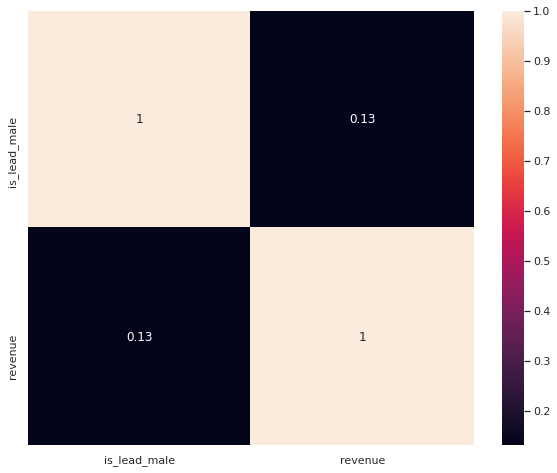

In [ ]:
heatmap1 = train_df[['is_lead_male', 'revenue']]
f,ax = plt.subplots(figsize=(10, 8))
sns.heatmap(heatmap1.corr(), annot=True)
plt.show()

Looks like there's not much of a correlation there. But it's not completely negligible to ignore the bias.

# Part 5 - External Dataset

I am going to use the imdb datasets link to get an external datase. 
Source: https://www.imdb.com/interfaces/ 
I will be using 'title.ratings.tsv.gz' from the above source. 
It contains the IMDb rating and votes information for titles
tconst (string) - alphanumeric unique identifier of the title --- this is the same as imdb_id, I am going to merge the original dataset with this one using this as the key.

averageRating – weighted average of all the individual user ratings

numVotes - number of votes the title has received

I am also going to rename these columns.

##Read and fillna 

In [ ]:
external_data = pd.read_csv(parent_dir + 'title.ratings.tsv', sep='\t')

In [ ]:
len(external_data)

1082394

In [ ]:
external_data.head()

tconst  averageRating  numVotes
0  tt0000001          5.600      1650
1  tt0000002          6.100       199
2  tt0000003          6.500      1359
3  tt0000004          6.200       121
4  tt0000005          6.200      2144

In [ ]:
external_data.rename(columns={'tconst':'imdb_id', 'averageRating':'rating', 'numVotes': 'totalVotes'}, inplace=True)

## Train Data

In [ ]:
train_additional = external_data[external_data['imdb_id'].isin(train_df['imdb_id'])]

In [ ]:
train_additional.head()

imdb_id  rating  totalVotes
1615  tt0004972   6.300       22354
1880  tt0006333   6.200        1516
3290  tt0012349   8.300      110202
4160  tt0015400   7.700        5486
4256  tt0015648   8.000       52099

In [ ]:
train_additional.columns

Index(['imdb_id', 'rating', 'totalVotes'], dtype='object')

In [ ]:
train_additional.isnull().sum()

imdb_id       0
rating        0
totalVotes    0
dtype: int64

In [ ]:
train_df.columns

Index(['id', 'belongs_to_collection', 'budget', 'genres', 'imdb_id',
       'original_language', 'original_title', 'overview', 'popularity',
       'production_companies', 'production_countries', 'release_date',
       'runtime', 'spoken_languages', 'status', 'title', 'Keywords', 'cast',
       'crew', 'revenue', 'has_homepage', 'has_tagline', 'is_collection_part',
       'log_revenue', 'day_of_week', 'month', 'year', 'cast_count',
       'na_gender_cast_count', 'female_cast_count', 'male_cast_count',
       'freq_cast_power', 'avg_freq_cast_power', 'lead_freq_cast_power',
       'lead1_freq_cast_power', 'is_lead_male'],
      dtype='object')

In [ ]:
train_df = train_df.merge(train_additional, on=['imdb_id'], how='left')

In [ ]:
train_df.isnull().sum()

id                       0
belongs_to_collection    0
budget                   0
genres                   0
imdb_id                  0
original_language        0
original_title           0
overview                 8
popularity               0
production_companies     0
production_countries     0
release_date             0
runtime                  0
spoken_languages         0
status                   0
title                    0
Keywords                 0
cast                     0
crew                     0
revenue                  0
has_homepage             0
has_tagline              0
is_collection_part       0
log_revenue              0
day_of_week              0
month                    0
year                     0
cast_count               0
na_gender_cast_count     0
female_cast_count        0
male_cast_count          0
freq_cast_power          0
avg_freq_cast_power      0
lead_freq_cast_power     0
lead1_freq_cast_power    0
is_lead_male             0
rating                   1
t

#### Finding and filling missing values

In [ ]:
train_df[pd.isnull(train_df['totalVotes'])]

id belongs_to_collection  budget  ... is_lead_male rating totalVotes
355  356                    []       0  ...            2    nan        nan

[1 rows x 38 columns]

I could find the totalVotes and rating as 1998 and 7.3 for the above record from https://www.imdb.com/title/tt4283892/ so I'll use the same to fill the missing data.

In [ ]:
train_df['rating'] = train_df['rating'].fillna(7.3)
train_df['totalVotes'] = train_df['totalVotes'].fillna(1998)

In [ ]:
train_df.isnull().sum()

id                       0
belongs_to_collection    0
budget                   0
genres                   0
imdb_id                  0
original_language        0
original_title           0
overview                 8
popularity               0
production_companies     0
production_countries     0
release_date             0
runtime                  0
spoken_languages         0
status                   0
title                    0
Keywords                 0
cast                     0
crew                     0
revenue                  0
has_homepage             0
has_tagline              0
is_collection_part       0
log_revenue              0
day_of_week              0
month                    0
year                     0
cast_count               0
na_gender_cast_count     0
female_cast_count        0
male_cast_count          0
freq_cast_power          0
avg_freq_cast_power      0
lead_freq_cast_power     0
lead1_freq_cast_power    0
is_lead_male             0
rating                   0
t

Write your answer here

## Test Data

In [ ]:
test_additional = external_data[external_data['imdb_id'].isin(test_df['imdb_id'])]

In [ ]:
test_additional.head()

imdb_id  rating  totalVotes
1639  tt0005078   6.600        2317
2512  tt0009369   5.900        1063
3484  tt0013140   7.000        3093
3857  tt0014429   8.100       17915
4246  tt0015624   7.900        6123

In [ ]:
test_additional.columns

Index(['imdb_id', 'rating', 'totalVotes'], dtype='object')

In [ ]:
test_additional.isnull().sum()

imdb_id       0
rating        0
totalVotes    0
dtype: int64

In [ ]:
test_df.columns

Index(['id', 'belongs_to_collection', 'budget', 'genres', 'imdb_id',
       'original_language', 'original_title', 'overview', 'popularity',
       'production_companies', 'production_countries', 'release_date',
       'runtime', 'spoken_languages', 'status', 'title', 'Keywords', 'cast',
       'crew', 'has_homepage', 'has_tagline', 'is_collection_part',
       'day_of_week', 'month', 'year'],
      dtype='object')

In [ ]:
test_df = test_df.merge(test_additional, on=['imdb_id'], how='left')

In [ ]:
test_df.isnull().sum()

id                        0
belongs_to_collection     0
budget                    0
genres                    0
imdb_id                   0
original_language         0
original_title            0
overview                 14
popularity                0
production_companies      0
production_countries      0
release_date              0
runtime                   0
spoken_languages          0
status                    2
title                     3
Keywords                  0
cast                      0
crew                      0
has_homepage              0
has_tagline               0
is_collection_part        0
day_of_week               0
month                     0
year                      0
rating                    2
totalVotes                2
dtype: int64

#### Finding and filling missing values

In [ ]:
test_df[pd.isnull(test_df['totalVotes'])]

id belongs_to_collection  budget  ...  year rating totalVotes
713   3714                    []  300000  ...  2016    nan        nan
1975  4976                    []  447524  ...  2015    nan        nan

[2 rows x 27 columns]

https://www.imdb.com/title/tt5310090/ : id-3714 (11,146 votes and 7.6 rating)

https://www.imdb.com/title/tt2690138/ : id-4976 (10,508 votes and 5.0 rating)


In [ ]:
test_df.loc[713, 'rating'] = 7.6
test_df.loc[713, 'totalVotes'] = 11146
test_df.loc[1975, 'rating'] = 5.0
test_df.loc[1975, 'totalVotes'] = 10508


In [ ]:
test_df.isnull().sum()

id                        0
belongs_to_collection     0
budget                    0
genres                    0
imdb_id                   0
original_language         0
original_title            0
overview                 14
popularity                0
production_companies      0
production_countries      0
release_date              0
runtime                   0
spoken_languages          0
status                    2
title                     3
Keywords                  0
cast                      0
crew                      0
has_homepage              0
has_tagline               0
is_collection_part        0
day_of_week               0
month                     0
year                      0
rating                    0
totalVotes                0
dtype: int64

## Analysis

I want to plot the Votes and ratings against revenue to find out any patterns. Also, I will generate heatmap to get the correlations with revenue.

I'd assume both votes and rating should be affecting the revenue and have a decent correlation with revenue.

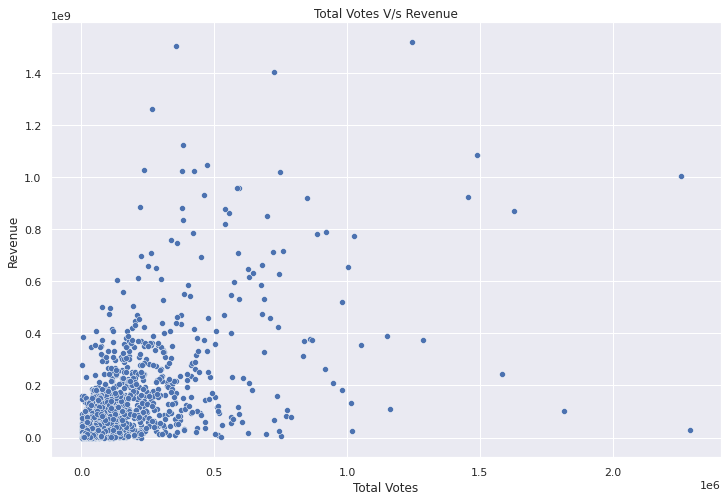

In [ ]:

plt.subplots(figsize=[12,8])
plot = sns.scatterplot(x='totalVotes', y='revenue', data=train_df)
plot.set_title('Total Votes V/s Revenue')
plot.set(xlabel='Total Votes', ylabel='Revenue')
plt.show()


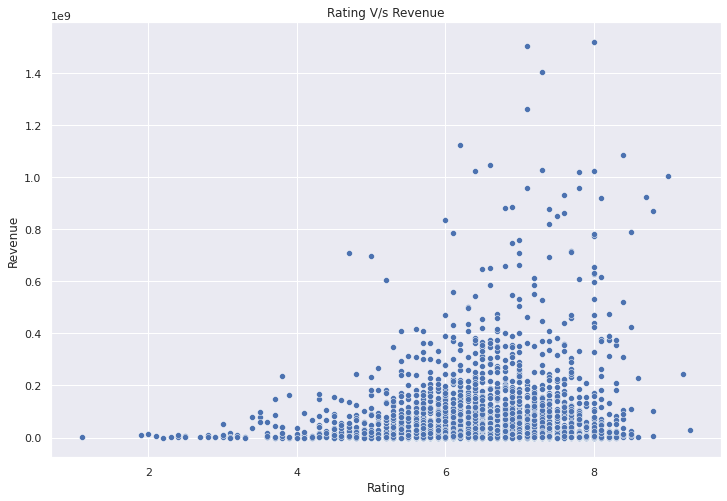

In [ ]:

plt.subplots(figsize=[12,8])
plot = sns.scatterplot(x='rating', y='revenue', data=train_df)
plot.set_title('Rating V/s Revenue')
plot.set(xlabel='Rating', ylabel='Revenue')
plt.show()


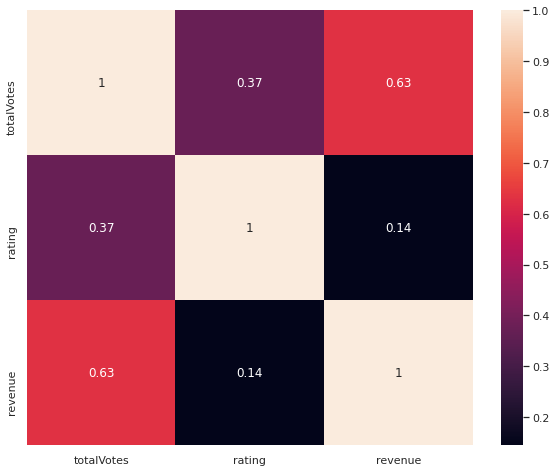

In [ ]:
heatmap1 = train_df[['totalVotes', 'rating', 'revenue']]
f,ax = plt.subplots(figsize=(10, 8))
sns.heatmap(heatmap1.corr(), annot=True)
plt.show()

Total Votes certainly seem to have a direct relation with revenue with a strong correlation of0.63. Also, from the graph we can see higher votes usually result in higher revenue with some outliers. 

Ratings v/s Revenue was more of a mixed graph with certain movies with high rating fenerating high revenue while some did not, and this was confirmed with a correlation of 0.14. 

However, I wouldn't completely discard the ratings data and see if I can still use it some how in predicting the revenue. 
I will definitely use the votes data though.

# Part 6 - Informative Plots

In [ ]:
train_df.columns

Index(['id', 'belongs_to_collection', 'budget', 'genres', 'imdb_id',
       'original_language', 'original_title', 'overview', 'popularity',
       'production_companies', 'production_countries', 'release_date',
       'runtime', 'spoken_languages', 'status', 'title', 'Keywords', 'cast',
       'crew', 'revenue', 'has_homepage', 'has_tagline', 'is_collection_part',
       'log_revenue', 'day_of_week', 'month', 'year', 'cast_count',
       'na_gender_cast_count', 'female_cast_count', 'male_cast_count',
       'freq_cast_power', 'avg_freq_cast_power', 'lead_freq_cast_power',
       'lead1_freq_cast_power', 'is_lead_male', 'rating', 'totalVotes'],
      dtype='object')

## Scatter plots

### Runtime

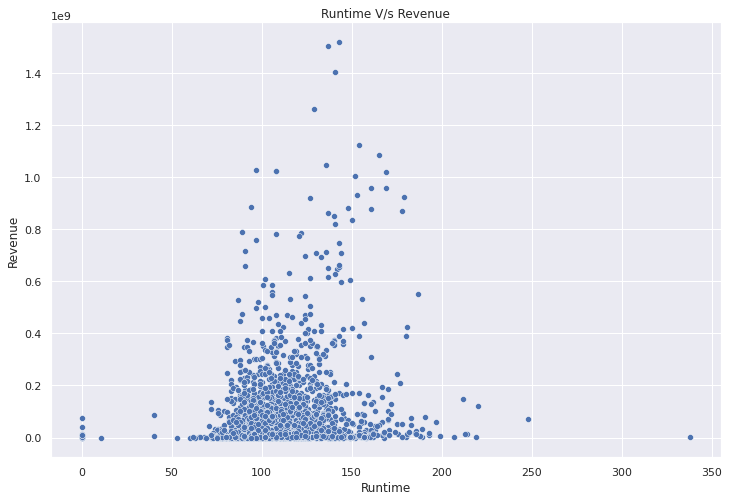

In [ ]:
plt.subplots(figsize=[12,8])
plot = sns.scatterplot(x='runtime', y='revenue', data=train_df)
plot.set_title('Runtime V/s Revenue')
plot.set(xlabel='Runtime', ylabel='Revenue')
plt.show()


I can't really see a direct relationship between runtime and revenue, mainly because I think most of the movies lie in the same ballpark range of runtime which is between ~90 to ~ 130 minutes. And some seem to be clustered with a continous revenue, and some are also spread out towards higher revenue. 
Then, I also see a movie with a runtime of ~340 minutes that generated relatively pretty low revenue. 
Also, there are some short films. 
I also see some movies with 0 runtime -- possibly this is data error or some spurious movies; I will choose to keep the data as is and make changes only if my predictions go too bad.
I am not sure if I can speak of a direct relationship between runtime and revenue given the plot. 

### Budget

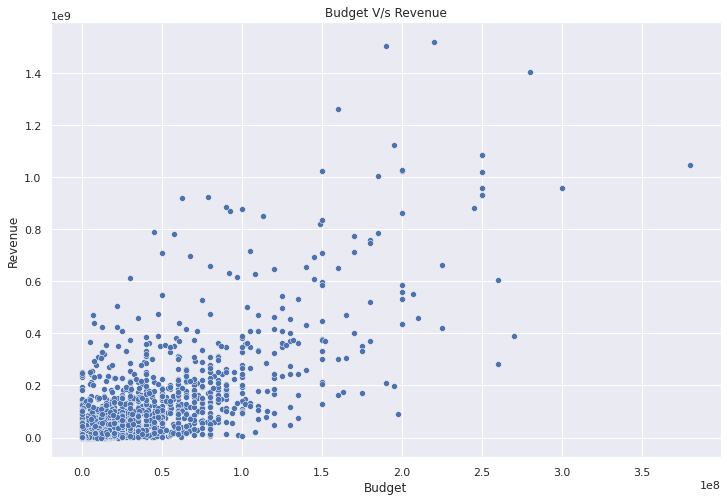

In [ ]:
plt.subplots(figsize=[12,8])
plot = sns.scatterplot(x='budget', y='revenue', data=train_df)
plot.set_title('Budget V/s Revenue')
plot.set(xlabel='Budget', ylabel='Revenue')
plt.show()


I would also want to visualize a log-log plot for the budget and revenue.

In [ ]:
train_df['log_budget'] = np.log(train_df['budget'] + 1)

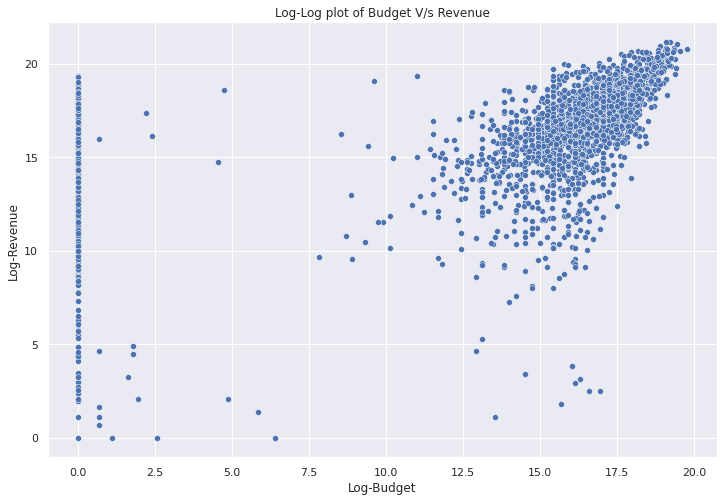

In [ ]:
plt.subplots(figsize=[12,8])
plot = sns.scatterplot(x='log_budget', y='log_revenue', data=train_df)
plot.set_title('Log-Log plot of Budget V/s Revenue')
plot.set(xlabel='Log-Budget', ylabel='Log-Revenue')
plt.show()


If this would have been a power law distribution we would have seen a straight line in the log-log plot above, but we see a pretty skewed distribution. I can see a possible reason would be that there is some discrepancy in data - 1. There are a lot of movies with 0 budget but with not-0 revenues which looks fishy, so possibly there's missing data (?) . 
2. The currencies of budget and/or revenue might not be consistent (?) -- I'm not sure. 

However, for now I'll keep the data as is and decide if I want to make any changes as my predictions go. 

I would like to get a ratio of budget to cast_count and plot the same against revenue to see how much budget per cast may have an effect. It is not exactly a budget per cast number since budget involves much more than cast budget and also the budget ratio within cast also varies a lot but we can still get an idea.

In [ ]:
train_df['budget_to_cast'] = train_df['budget']/train_df['cast_count']

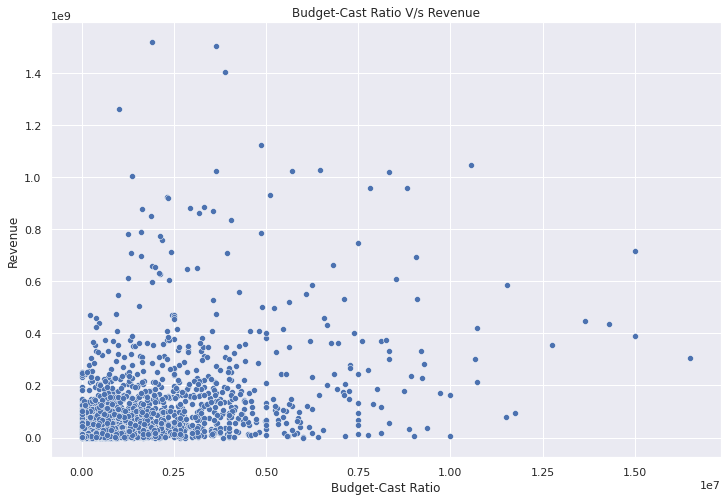

In [ ]:

plt.subplots(figsize=[12,8])
plot = sns.scatterplot(x='budget_to_cast', y='revenue', data=train_df)
plot.set_title('Budget-Cast Ratio V/s Revenue')
plot.set(xlabel='Budget-Cast Ratio', ylabel='Revenue')
plt.show()


The budget-cast ratio seems to be a bit scattered too but it's not all heading towards the right top quadrant as we saw in the previous plot.

### Popularity, Total votes and Rating

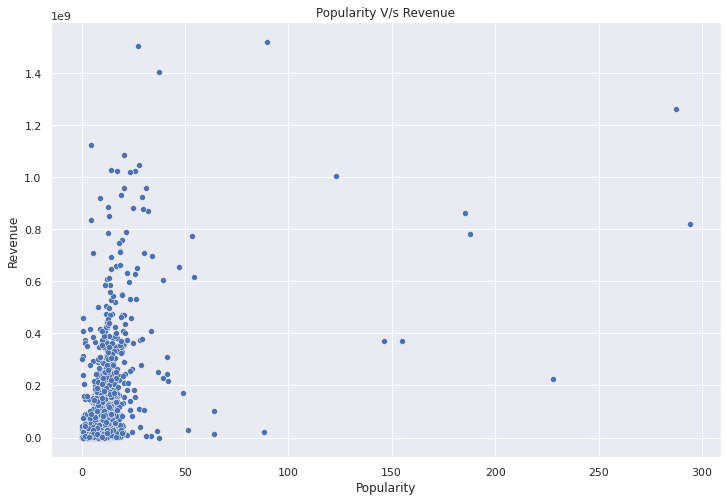

In [ ]:

plt.subplots(figsize=[12,8])
plot = sns.scatterplot(x='popularity', y='revenue', data=train_df)
plot.set_title('Popularity V/s Revenue')
plot.set(xlabel='Popularity', ylabel='Revenue')
plt.show()


I would have expected the revenue to go up as the popularity to goes up, or there being some linear realtion between the 2, but it doesn't look like so because we can see that the movies in the same range of popularity having a varied range of revenue.

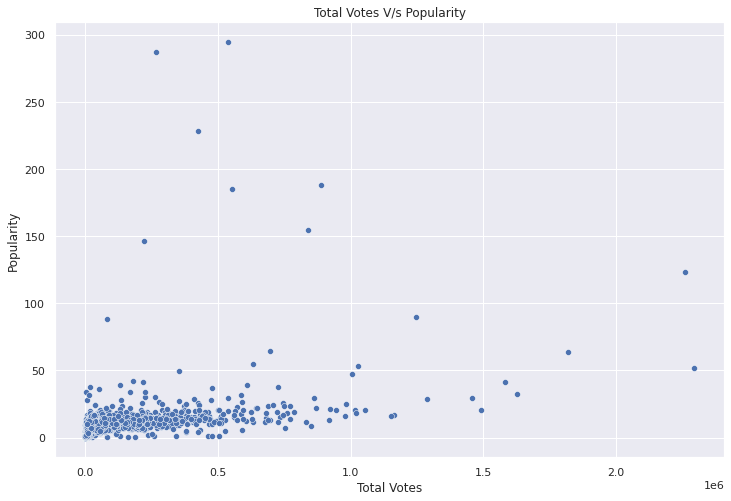

In [ ]:
plt.subplots(figsize=[12,8])
plot = sns.scatterplot(x='totalVotes', y='popularity', data=train_df)
plot.set_title('Total Votes V/s Popularity')
plot.set(xlabel='Total Votes', ylabel='Popularity')
plt.show()


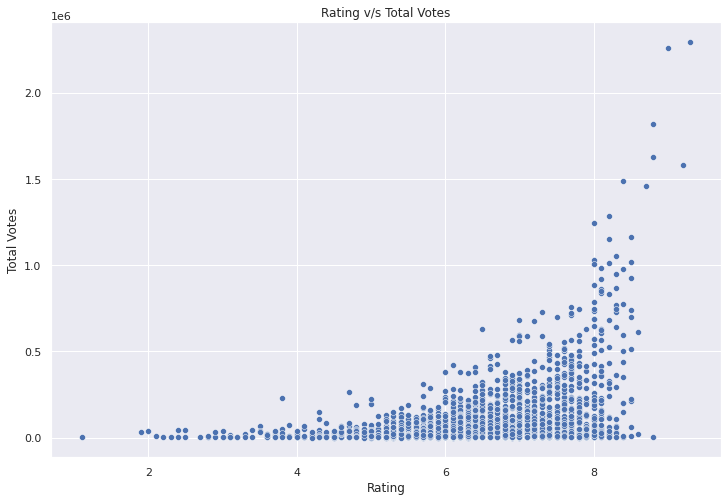

In [ ]:
plt.subplots(figsize=[12,8])
plot = sns.scatterplot(x='rating', y='totalVotes', data=train_df)
plot.set_title('Rating v/s Total Votes')
plot.set(xlabel='Rating', ylabel='Total Votes')
plt.show()


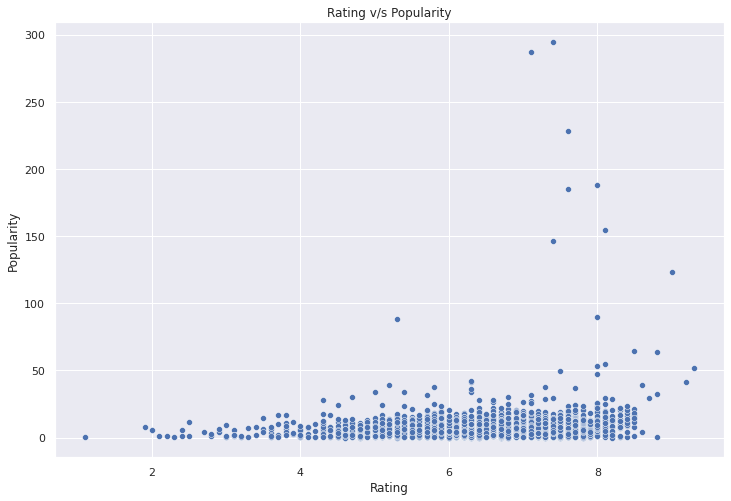

In [ ]:

plt.subplots(figsize=[12,8])
plot = sns.scatterplot(x='rating', y='popularity', data=train_df)
plot.set_title('Rating v/s Popularity')
plot.set(xlabel='Rating', ylabel='Popularity')
plt.show()


I wanted to see how are popularity, rating and Total Votes related to each other. Apparently, movies' rating do not seem to impact the popularity as much, though the total votes are higher for higher rated movies.

Surprisingly, even total votes and popularity do not go hand in hand. 

## Histogram/Bar plot

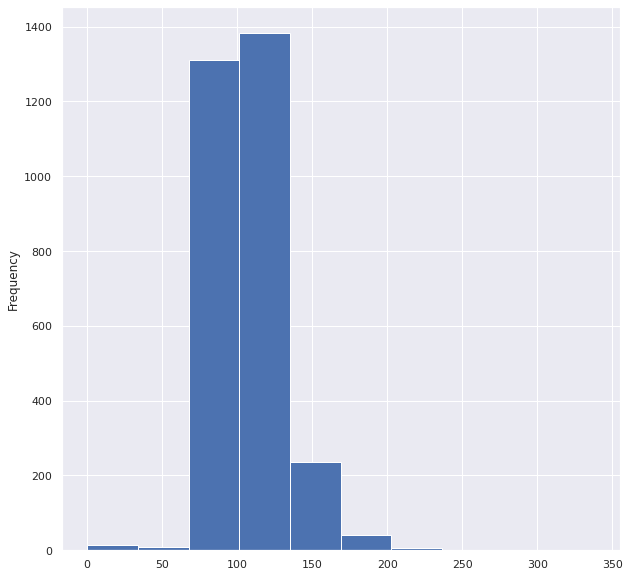

In [ ]:
train_df['runtime'].plot(kind='hist');

### Genres Analysis

In [ ]:
train_df['genres'][1]

[{'id': 35, 'name': 'Comedy'},
 {'id': 18, 'name': 'Drama'},
 {'id': 10751, 'name': 'Family'},
 {'id': 10749, 'name': 'Romance'}]

In [ ]:
train_df['genres_count'] = train_df['genres'].apply(lambda x : len([genre['name'] for genre in x]))

In [ ]:
train_df['genres_count'].isnull().sum()

0

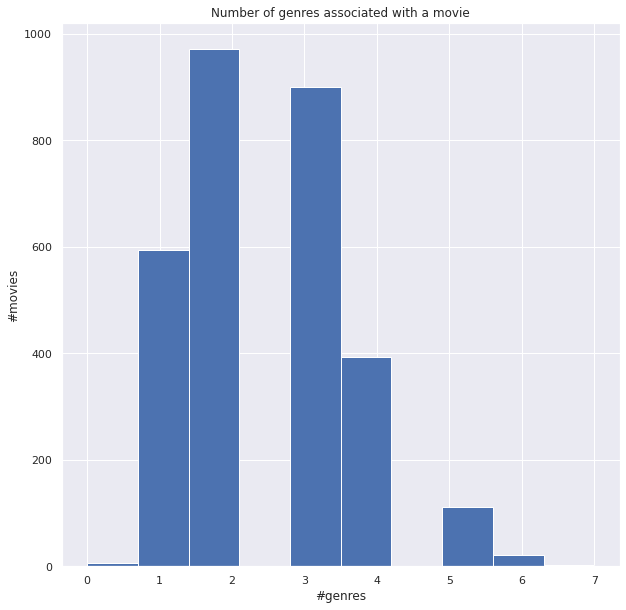

In [ ]:
ax = train_df['genres_count'].plot(kind='hist', title='Number of genres associated with a movie');
ax.set_xlabel('#genres');
ax.set_ylabel('#movies');

Now, I will map each genre to a revenue -- this will be the revenue of the movies which is associated with that genre and then sum the revenues against each genre to get the total revenue for that genre.


This will have revenues duplicated, for example,  movies with 2 genres should split the revenue among the genres but since I can't alot a percentage share, I will take the liberty to just add the revenue as it is to just get a sense of total revenues by genre. In this process, I will also count the #movies released by a genre -- so I can normalize the total revenue by #movies as well.

In [ ]:
sub_df = train_df[['genres', 'revenue']]
cols = ['genre', 'revenue']
genre_revenue = pd.DataFrame([], columns=cols)

for x in sub_df.itertuples(index=False):
  for genre in x[0]:
    genre_revenue = genre_revenue.append(pd.Series([genre['name'], x[1]], index=cols), ignore_index=True)
  

In [ ]:
genre_revenue

genre    revenue
0       Comedy   12314651
1       Comedy   95149435
2        Drama   95149435
3       Family   95149435
4      Romance   95149435
...        ...        ...
7506    Comedy  171963386
7507   Romance  171963386
7508  Thriller   82087155
7509    Action   82087155
7510   Mystery   82087155

[7511 rows x 2 columns]

Now, I will get the #movies and country_revenue

In [ ]:
genre_revenue = genre_revenue.groupby('genre').agg({'genre':'count', 'revenue':'sum'})
genre_revenue.rename(columns={'genre':'#movies', 'revenue':'genre_revenue'}, inplace=True)
genre_revenue['genre'] = genre_revenue.index
genre_revenue.reset_index(drop=True, inplace=True)
genre_revenue = genre_revenue[['genre', '#movies', 'genre_revenue']]
genre_revenue

genre  #movies  genre_revenue
0            Action      741    82283193867
1         Adventure      439    77180369998
2         Animation      141    20830507010
3            Comedy     1028    62580263721
4             Crime      469    27901408828
5       Documentary       87      403506794
6             Drama     1531    69516699191
7            Family      260    36113426664
8           Fantasy      232    34328096420
9           Foreign       31       58100126
10          History      132     5070546615
11           Horror      301    15865430318
12            Music      100     4287089768
13          Mystery      225    13417641845
14          Romance      571    30094559216
15  Science Fiction      290    35486481131
16         TV Movie        1       42000000
17         Thriller      789    53917610066
18              War      100     4991586809
19          Western       43     2208937320

Let's also add the normalized revenue.

In [ ]:
genre_revenue['normalized_genre_revenue'] = genre_revenue['genre_revenue']/genre_revenue['#movies']
genre_revenue

genre  #movies  genre_revenue  normalized_genre_revenue
0            Action      741    82283193867             111043446.514
1         Adventure      439    77180369998             175809498.856
2         Animation      141    20830507010             147734092.270
3            Comedy     1028    62580263721              60875742.919
4             Crime      469    27901408828              59491276.819
5       Documentary       87      403506794               4638009.126
6             Drama     1531    69516699191              45406073.933
7            Family      260    36113426664             138897794.862
8           Fantasy      232    34328096420             147965932.845
9           Foreign       31       58100126               1874197.613
10          History      132     5070546615              38413231.932
11           Horror      301    15865430318              52709070.824
12            Music      100     4287089768              42870897.680
13          Mystery      225    13417641845              59633963.756
14          Romance      571    30094559216              52705007.384
15  Science Fiction      290    35486481131             122367176.314
16         TV Movie        1       42000000              42000000.000
17         Thriller      789    53917610066              68336641.402
18              War      100     4991586809              49915868.090
19          Western       43     2208937320              51370635.349

First, let's plot the #movies released by genre.

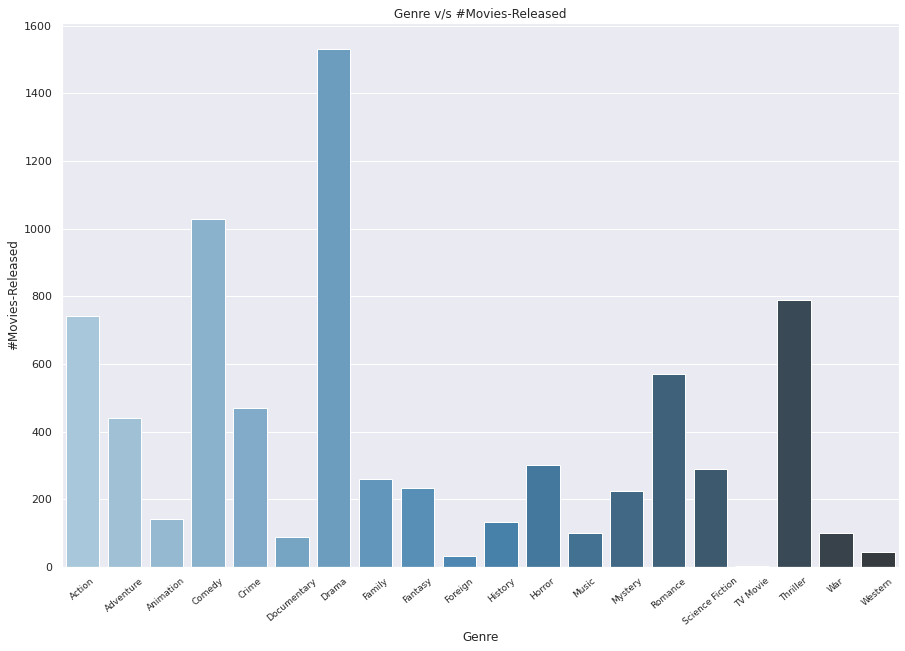

In [ ]:
plt.subplots(figsize=[15,10])
plot = sns.barplot(x='genre', y='#movies', data=genre_revenue, palette='Blues_d')
plot.set_title('Genre v/s #Movies-Released');
plot.set(xlabel='Genre', ylabel='#Movies-Released')
plot.set_xticklabels(plot.get_xticklabels(), fontsize=9)
plt.xticks(rotation=40)

plt.show()

This confirms are word cloud results. We do see that movies are dominated by Drama, Action, Comedy, Thriller genres.

Let's plot the genre v/s genre revenue plot.

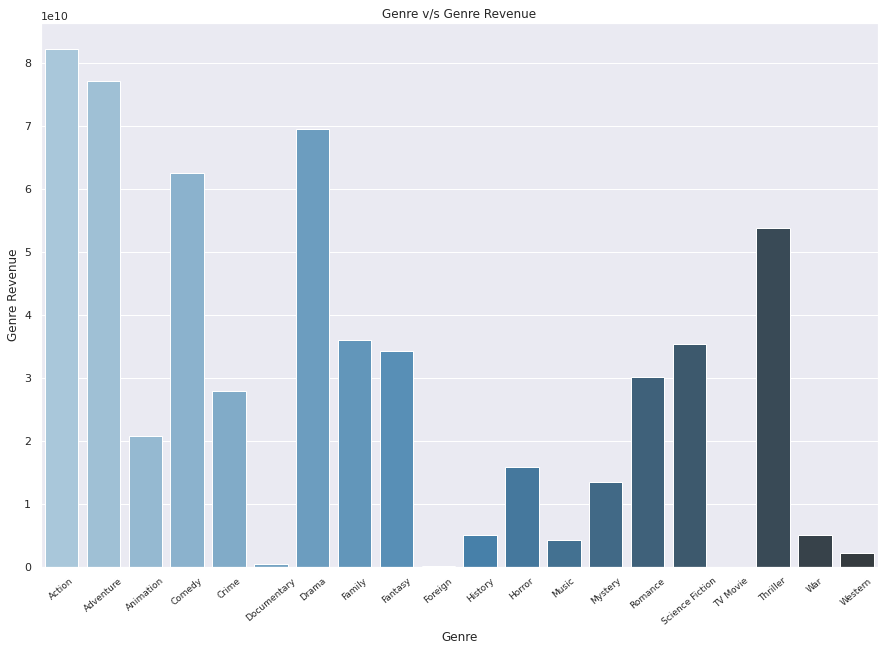

In [ ]:
plt.subplots(figsize=[15,10])
plot = sns.barplot(x='genre', y='genre_revenue', data=genre_revenue, palette='Blues_d')
plot.set_title('Genre v/s Genre Revenue');
plot.set(xlabel='Genre', ylabel='Genre Revenue')
plot.set_xticklabels(plot.get_xticklabels(), fontsize=9)
plt.xticks(rotation=40)

plt.show()

Looks like Action, Adventure and drama are the big revenue baggers. 

Let's also plot using normalized revenue.

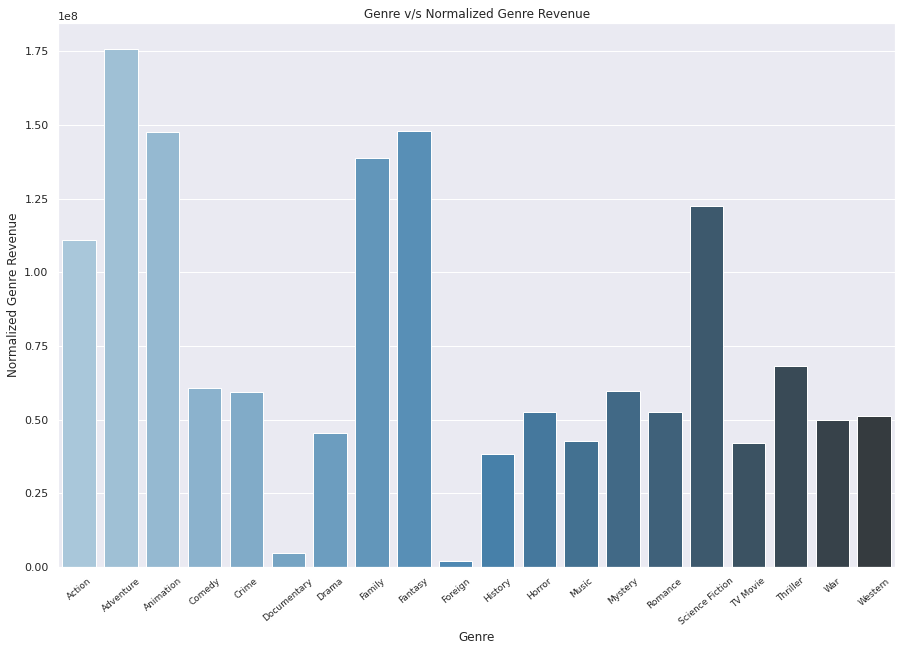

In [ ]:
plt.subplots(figsize=[15,10])
plot = sns.barplot(x='genre', y='normalized_genre_revenue', data=genre_revenue, palette='Blues_d')
plot.set_title('Genre v/s Normalized Genre Revenue');
plot.set(xlabel='Genre', ylabel='Normalized Genre Revenue')
plot.set_xticklabels(plot.get_xticklabels(), fontsize=9)
plt.xticks(rotation=40)

plt.show()

Adventure still remains on the higher end even with the normalized revenue, however action and drama drop down.

### Production-Countries Analysis

In [ ]:
train_df['production_countries'][1]

[{'iso_3166_1': 'US', 'name': 'United States of America'}]

In [ ]:
train_df['prod_ctry_count'] = train_df['production_countries'].apply(lambda x : len([pc['name'] for pc in x]))

In [ ]:
train_df['prod_ctry_count'].isnull().sum()

0

In [ ]:
max(train_df['prod_ctry_count'])

8

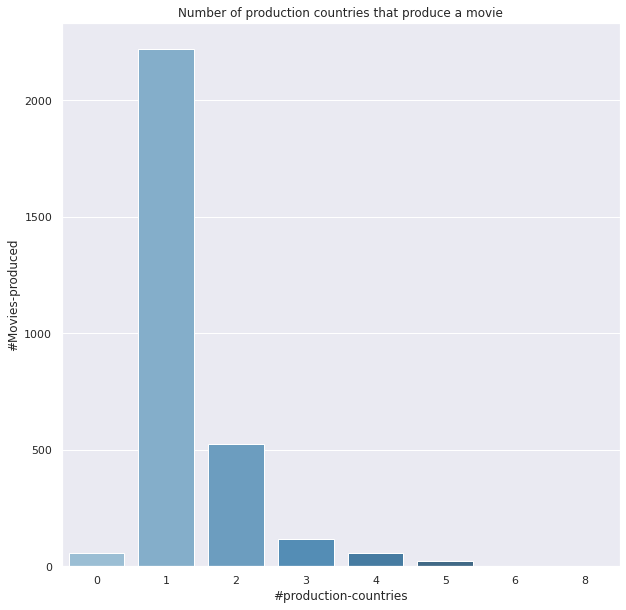

In [ ]:
plot = sns.countplot(x='prod_ctry_count', data=train_df, palette='Blues_d')
plot.set_title('Number of production countries that produce a movie');
plot.set(xlabel='#production-countries', ylabel='#Movies-produced');

Most of the movies seem to be produced by 1 production counry.

Now, I will map each production country to a revenue -- this will be the revenue of the movies which have that production-country and then sum the revenues against each country to get the total revenue for that production country. 


This will have revenues duplicated, for example,  movies with 2 production-companies will should split the revenue among the countries but since I do not know the percentage share, I will take the liberty to just add the revenue as it is to just get a sense of total revenues by country. In this process, I will also count the #movies released by a country -- so I can normalize the total revenue by #movies later on if need be.

In [ ]:
pctr_revenue = train_df[['production_countries', 'revenue']]
cols = ['country', 'revenue']
ctry_revenue = pd.DataFrame([], columns=cols)

for x in pctr_revenue.itertuples(index=False):
  for ctry in x[0]:
    ctry_revenue = ctry_revenue.append(pd.Series([ctry['name'], x[1]], index=cols), ignore_index=True)
  

In [ ]:
ctry_revenue

country    revenue
0     United States of America   12314651
1     United States of America   95149435
2     United States of America   13092000
3                        India   16000000
4                  South Korea    3923970
...                        ...        ...
3974                   Denmark     180590
3975                    Sweden     180590
3976  United States of America   89456761
3977  United States of America  171963386
3978  United States of America   82087155

[3979 rows x 2 columns]

Now, I will get the #movies and country_revenue

In [ ]:
ctry_revenue = ctry_revenue.groupby('country').agg({'country':'count', 'revenue':'sum'})
ctry_revenue.rename(columns={'country':'#movies', 'revenue':'country_revenue'}, inplace=True)
ctry_revenue['country'] = ctry_revenue.index
ctry_revenue.reset_index(drop=True, inplace=True)
ctry_revenue = ctry_revenue[['country', '#movies', 'country_revenue']]
ctry_revenue

country  #movies  country_revenue
0                    Algeria        1           921548
1                  Argentina        6         67192469
2                  Australia       61       4041396552
3                    Austria        8        199873861
4                    Bahamas        3        149252232
..                       ...      ...              ...
69                   Ukraine        2         10212668
70      United Arab Emirates        9        963490546
71            United Kingdom      380      27639015794
72  United States of America     2282     187048227401
73                   Uruguay        1        163794509

[74 rows x 3 columns]

Let's also add the normalized revenue.

In [ ]:
ctry_revenue['normalized_ctry_revenue'] = ctry_revenue['country_revenue']/ctry_revenue['#movies']
ctry_revenue

country  #movies  country_revenue  normalized_ctry_revenue
0                    Algeria        1           921548               921548.000
1                  Argentina        6         67192469             11198744.833
2                  Australia       61       4041396552             66252402.492
3                    Austria        8        199873861             24984232.625
4                    Bahamas        3        149252232             49750744.000
..                       ...      ...              ...                      ...
69                   Ukraine        2         10212668              5106334.000
70      United Arab Emirates        9        963490546            107054505.111
71            United Kingdom      380      27639015794             72734252.089
72  United States of America     2282     187048227401             81966795.531
73                   Uruguay        1        163794509            163794509.000

[74 rows x 4 columns]

First, let's plot the #movies released by country.

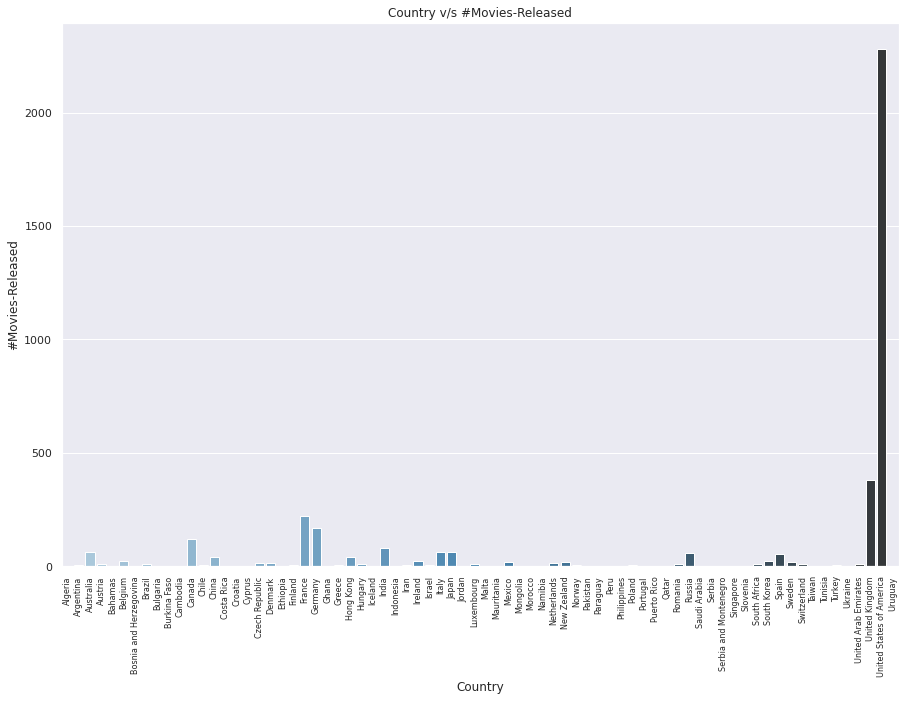

In [ ]:
plt.subplots(figsize=[15,10])
plot = sns.barplot(x='country', y='#movies', data=ctry_revenue, palette='Blues_d')
plot.set_title('Country v/s #Movies-Released');
plot.set(xlabel='Country', ylabel='#Movies-Released')
plot.set_xticklabels(plot.get_xticklabels(), fontsize=8)
plt.xticks(rotation=90)

plt.show()

Since this is a skewed plot, I am assuming the country revenue will also be a skewed plot. Let's check.

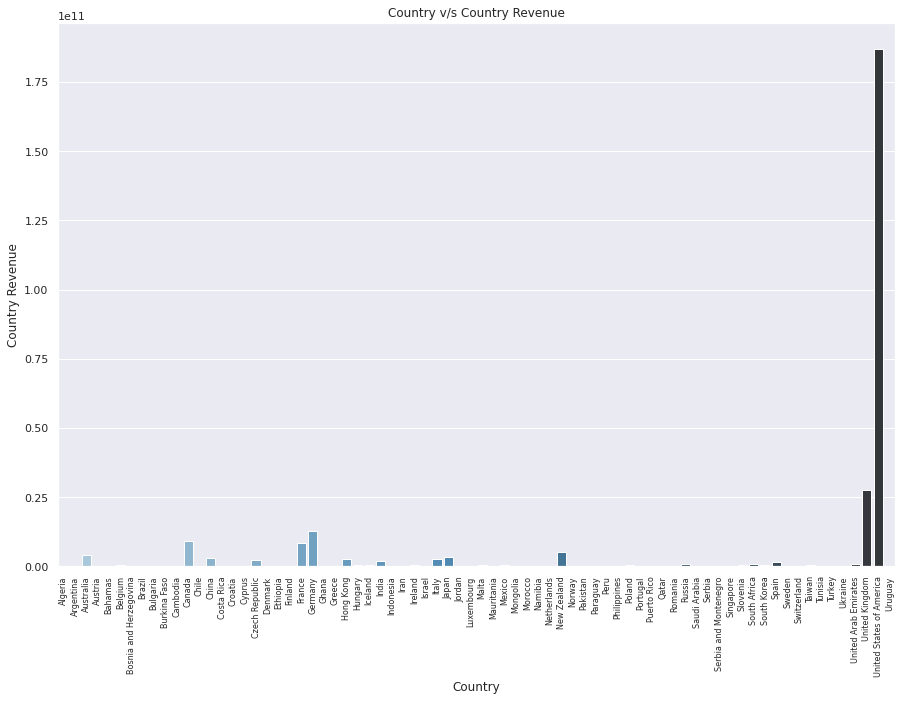

In [ ]:
plt.subplots(figsize=[15,10])
plot = sns.barplot(x='country', y='country_revenue', data=ctry_revenue, palette='Blues_d')
plot.set_title('Country v/s Country Revenue');
plot.set(xlabel='Country', ylabel='Country Revenue')
plot.set_xticklabels(plot.get_xticklabels(), fontsize=8)
plt.xticks(rotation=90)

plt.show()

As expected the total revenue by country is absurdly skewed.
So, we will plot using normalized revenue.

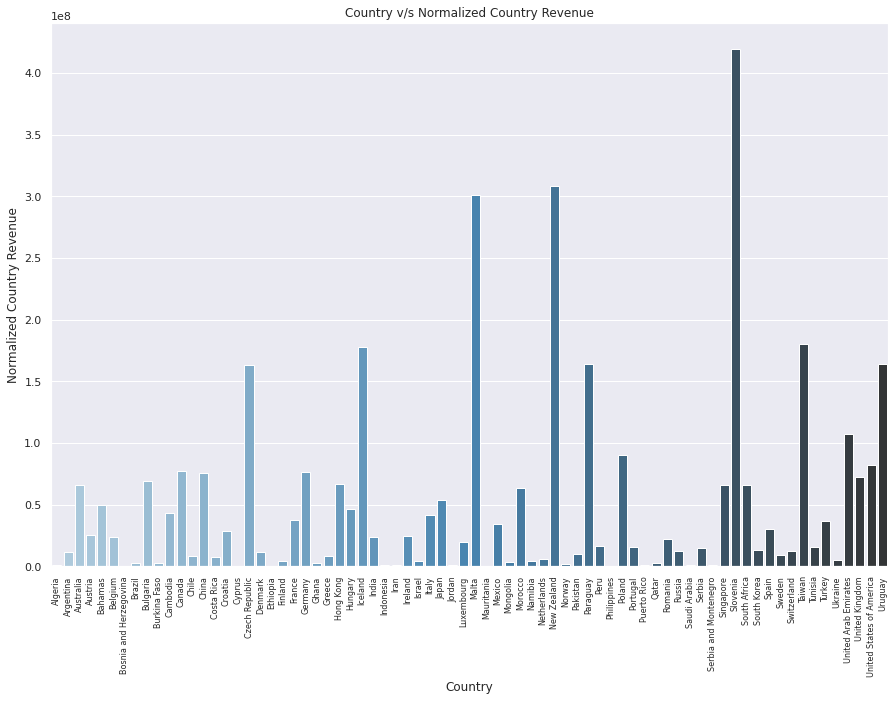

In [ ]:
plt.subplots(figsize=[15,10])
plot = sns.barplot(x='country', y='normalized_ctry_revenue', data=ctry_revenue, palette='Blues_d')
plot.set_title('Country v/s Normalized Country Revenue');
plot.set(xlabel='Country', ylabel='Normalized Country Revenue')
plot.set_xticklabels(plot.get_xticklabels(), fontsize=8)
plt.xticks(rotation=90)

plt.show()

This seems to give us a better picture of the revenue by country. Although, we can't really say that it is unbiased completely, because we treated the entire revenue of a movie to account for all of its production countries individually. Nevertheless, it gives us some idea of revenue/#movies-released ratio by country.

### Production-Companies Analysis

In [ ]:
train_df['production_companies'][1]

[{'id': 2, 'name': 'Walt Disney Pictures'}]

In [ ]:
train_df['prod_companies_count'] = train_df['production_companies'].apply(lambda x : len([pc['name'] for pc in x]))

In [ ]:
train_df['prod_companies_count'].isnull().sum()

0

In [ ]:
max(train_df['prod_companies_count'])

17

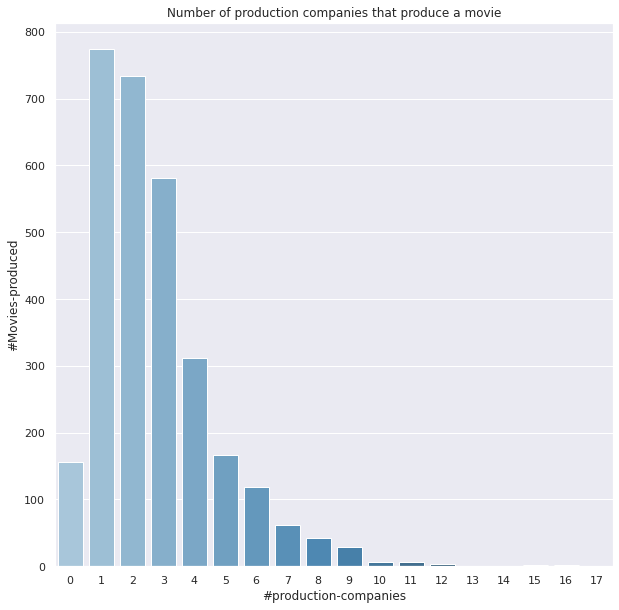

In [ ]:
plot = sns.countplot(x='prod_companies_count', data=train_df, palette='Blues_d')
plot.set_title('Number of production companies that produce a movie');
plot.set(xlabel='#production-companies', ylabel='#Movies-produced');

Now, I will map each production company to a revenue -- this will be the revenue of the movies which have that production-company and then sum the revenues against each company to get the total revenue for that production company. 


This will have revenues duplicated, for example,  movies with 2 production-companies should split the revenue among the companies but since I do not know the percentage share, I will take the liberty to just add the revenue as it is to just get a sense of total revenues by company. In this process, I will also count the #movies released by a company -- so I can normalize the total revenue by #movies.

In [ ]:
sub_df = train_df[['production_companies', 'revenue']]
cols = ['prod_company', 'revenue']
pc_revenue = pd.DataFrame([], columns=cols)

for x in sub_df.itertuples(index=False):
  for pc in x[0]:
    pc_revenue = pc_revenue.append(pd.Series([pc['name'], x[1]], index=cols), ignore_index=True)
  

In [ ]:
pc_revenue

prod_company   revenue
0            Paramount Pictures  12314651
1                United Artists  12314651
2     Metro-Goldwyn-Mayer (MGM)  12314651
3          Walt Disney Pictures  95149435
4                    Bold Films  13092000
...                         ...       ...
8090      Vertigo Entertainment  82087155
8091               Gotham Group  82087155
8092                Tailor Made  82087155
8093                Mango Farms  82087155
8094    Quick Six Entertainment  82087155

[8095 rows x 2 columns]

Now, I will get the #movies and companies_revenue

In [ ]:
pc_revenue = pc_revenue.groupby('prod_company').agg({'prod_company':'count', 'revenue':'sum'})
pc_revenue.rename(columns={'prod_company':'#movies', 'revenue':'company_revenue'}, inplace=True)
pc_revenue['prod_company'] = pc_revenue.index
pc_revenue.reset_index(drop=True, inplace=True)
pc_revenue = pc_revenue[['prod_company', '#movies', 'company_revenue']]
pc_revenue

prod_company  #movies  company_revenue
0     "DIA" Productions GmbH & Co. KG        1         44350926
1                           1000 Volt        1           138730
2                  1019 Entertainment        1          2801508
3               10th Hole Productions        2         34829670
4                           120 Films        1         49100000
...                               ...      ...              ...
3690                      Реал-Дакота        1          5249225
3691                    Роскинопрокат        1           234748
3692                              СТВ        1           243000
3693                    Флагман-Трейд        1           234748
3694                             Фокс        1         55635037

[3695 rows x 3 columns]

Let's also add the normalized revenue.

In [ ]:
pc_revenue['normalized_company_revenue'] = pc_revenue['company_revenue']/pc_revenue['#movies']
pc_revenue

prod_company  ...  normalized_company_revenue
0     "DIA" Productions GmbH & Co. KG  ...                44350926.000
1                           1000 Volt  ...                  138730.000
2                  1019 Entertainment  ...                 2801508.000
3               10th Hole Productions  ...                17414835.000
4                           120 Films  ...                49100000.000
...                               ...  ...                         ...
3690                      Реал-Дакота  ...                 5249225.000
3691                    Роскинопрокат  ...                  234748.000
3692                              СТВ  ...                  243000.000
3693                    Флагман-Трейд  ...                  234748.000
3694                             Фокс  ...                55635037.000

[3695 rows x 4 columns]

There are too many companies to plot.

Let's do some further analysis.

First, I will find the companies with higher #movies produced, higher revenue, and higher normalized revenue individually as 3 categories.

In [ ]:
pc_revenue.sort_values('#movies', ascending=False).head(30)

prod_company  ...  normalized_company_revenue
3514                            Warner Bros.  ...               120334673.550
3403                      Universal Pictures  ...               109670828.096
2458                      Paramount Pictures  ...               124783063.901
3362  Twentieth Century Fox Film Corporation  ...               113961915.667
738                        Columbia Pictures  ...               120284417.330
2106               Metro-Goldwyn-Mayer (MGM)  ...                68721455.667
2271                         New Line Cinema  ...               145159176.373
3322                     Touchstone Pictures  ...                76546547.302
3505                    Walt Disney Pictures  ...               303777082.548
739            Columbia Pictures Corporation  ...                75911345.016
3342                        TriStar Pictures  ...                78391981.698
2718                        Relativity Media  ...               111337606.188
561                                   Canal+  ...                44320248.609
3396                          United Artists  ...                62731346.136
2160                           Miramax Films  ...                51829712.675
3462               Village Roadshow Pictures  ...               139645381.444
2712                     Regency Enterprises  ...               105011750.419
316                                BBC Films  ...                20106736.533
974                       Dune Entertainment  ...               168699729.367
3592                     Working Title Films  ...               107563052.833
1239                Fox Searchlight Pictures  ...                47225870.862
1879                               Lionsgate  ...                72128865.750
3110                             StudioCanal  ...                50162012.214
965                           DreamWorks SKG  ...               187110073.444
1231                       Fox 2000 Pictures  ...               103727195.720
1479                      Hollywood Pictures  ...                51769026.583
2397                          Orion Pictures  ...                30096600.542
3120                    Summit Entertainment  ...               121310733.500
158                     Amblin Entertainment  ...               230780010.261
918                          Dimension Films  ...                71010524.261

[30 rows x 4 columns]

In [ ]:
pc_revenue.sort_values('company_revenue', ascending=False).head(30)

prod_company  ...  normalized_company_revenue
3514                            Warner Bros.  ...               120334673.550
3403                      Universal Pictures  ...               109670828.096
2458                      Paramount Pictures  ...               124783063.901
3505                    Walt Disney Pictures  ...               303777082.548
3362  Twentieth Century Fox Film Corporation  ...               113961915.667
738                        Columbia Pictures  ...               120284417.330
2271                         New Line Cinema  ...               145159176.373
1829                      Legendary Pictures  ...               357564820.368
2106               Metro-Goldwyn-Mayer (MGM)  ...                68721455.667
2718                        Relativity Media  ...               111337606.188
158                     Amblin Entertainment  ...               230780010.261
2039                          Marvel Studios  ...               661596618.250
2738                  Revolution Sun Studios  ...               655469382.875
974                       Dune Entertainment  ...               168699729.367
965                           DreamWorks SKG  ...               187110073.444
3580                           WingNut Films  ...               559200424.000
3462               Village Roadshow Pictures  ...               139645381.444
3322                     Touchstone Pictures  ...                76546547.302
2395                           Original Film  ...               227934116.143
3159                       TSG Entertainment  ...               291025417.625
739            Columbia Pictures Corporation  ...                75911345.016
2539                 Pixar Animation Studios  ...               532351327.875
3342                        TriStar Pictures  ...                78391981.698
821                         DC Entertainment  ...               564771376.429
1665                 Jerry Bruckheimer Films  ...               561781952.286
1056                         Eon Productions  ...               279534117.429
910                  Di Bonaventura Pictures  ...               425142483.333
3361         Twentieth Century Fox Animation  ...               418150106.000
444                         Blue Sky Studios  ...               458239231.000
1435                          Hasbro Studios  ...               818674036.750

[30 rows x 4 columns]

Most companies have the same ranking.

In [ ]:
pc_revenue.sort_values('normalized_company_revenue', ascending=False).head(30)

prod_company  ...  normalized_company_revenue
2638        Québec Production Services Tax Credit  ...              1506249360.000
735   Colorado Office of Film, Television & Media  ...              1506249360.000
97                      Abu Dhabi Film Commission  ...              1506249360.000
1576                        Indochina Productions  ...              1123746996.000
1506                             Hurwitz Creative  ...              1028570889.000
2896                      Second Mate Productions  ...               961000000.000
312                                           B24  ...               880674609.000
2073                   Media Rights Capital (MRC)  ...               861635974.000
2378                               One Race Films  ...               826593135.000
3510                               Wanda Pictures  ...               820580447.000
801                         Cruel & Unusual Films  ...               820580447.000
3146                             TENCENT PICTURES  ...               820580447.000
1435                               Hasbro Studios  ...               818674036.750
1739                                Kinberg Genre  ...               783112979.000
3229                         The Donners' Company  ...               783112979.000
515                             Bulletproof Cupid  ...               773328629.000
3507          Walt Disney Studios Motion Pictures  ...               758539785.000
3503                Walt Disney Animation Studios  ...               747503542.000
1070                             Esperanto Filmoj  ...               716392705.000
3053                                SprocketHeads  ...               709709780.000
1558                        Imprint Entertainment  ...               704159404.500
2039                               Marvel Studios  ...               661596618.250
2738                       Revolution Sun Studios  ...               655469382.875
1973                     Mad Hatter Entertainment  ...               609123048.000
186                                   Angry Films  ...               604942143.000
821                              DC Entertainment  ...               564771376.429
1665                      Jerry Bruckheimer Films  ...               561781952.286
1461                                 Heyday Films  ...               559380790.500
3580                                WingNut Films  ...               559200424.000
1462                                 Heyday films  ...               551339730.000

[30 rows x 4 columns]

The ranking drastically changes now.

## Line Plots

### Yearly revenue trend for top genres

I'm defining the top genres by the #movies-released for that genre. By the analysis above Drama, Comedy, Thriller, and Action are the top 4 genres.

In [ ]:
sub_df = train_df[['genres', 'revenue', 'year']]
cols = ['genre', 'revenue', 'year']
genre_trend = pd.DataFrame([], columns=cols)

for x in sub_df.itertuples(index=False):
  for genre in x[0]:
    genre_trend = genre_trend.append(pd.Series([genre['name'], x[1], x[2]], index=cols), ignore_index=True)
  

In [ ]:
genre_trend

genre    revenue  year
0       Comedy   12314651  2015
1       Comedy   95149435  2004
2        Drama   95149435  2004
3       Family   95149435  2004
4      Romance   95149435  2004
...        ...        ...   ...
7506    Comedy  171963386  2004
7507   Romance  171963386  2004
7508  Thriller   82087155  2011
7509    Action   82087155  2011
7510   Mystery   82087155  2011

[7511 rows x 3 columns]

In [ ]:
genre_trend.year = genre_trend.year.astype(float) 
genre_trend.revenue = genre_trend.revenue.astype(float)

In [ ]:
top_genre = genre_trend[(genre_trend['genre'] == 'Drama') | (genre_trend['genre'] == 'Comedy') | 
                        (genre_trend['genre'] == 'Thriller') | (genre_trend['genre'] == 'Action')]

In [ ]:
top_genre_groupy = top_genre.groupby(['genre', 'year'], as_index=False).agg({'genre': 'last', 'revenue': 'count'})
top_genre_groupy.rename(columns = {'revenue': '#movies-released'}, inplace=True)

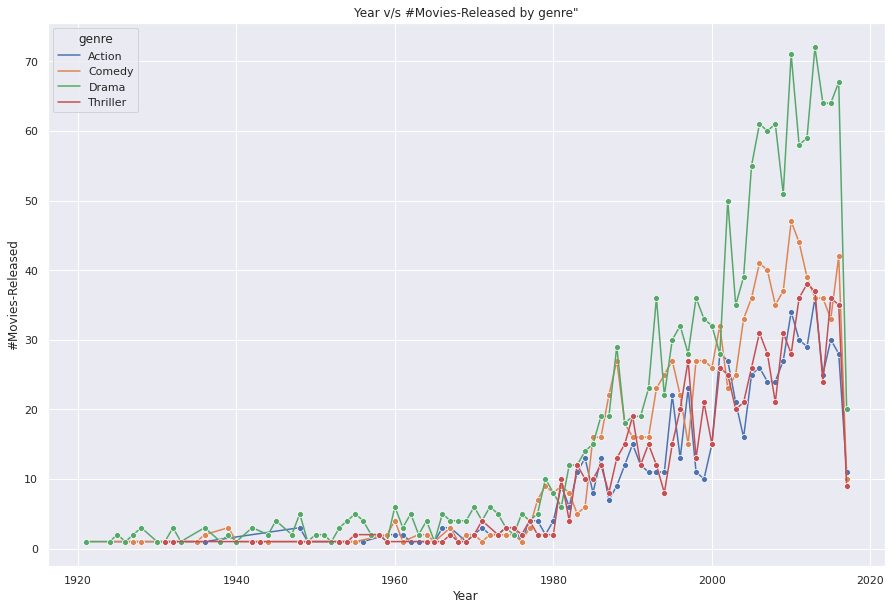

In [ ]:
plt.subplots(figsize=[15,10])
plot = sns.lineplot(x='year', y='#movies-released', hue='genre', data=top_genre_groupy, ci=None, marker='o')
plot.set_title('Year v/s #Movies-Released by genre"');
plot.set(xlabel='Year', ylabel='#Movies-Released')
plt.show()

Looks like the number of Drama movies got a high jump in the 2000's. But, we should not disregard the fact that we saw earlier that we saw less number of movies being released in the 1900's in general. 
But, even then if we compare the 4 genres w.r.t the #movies-released, Drama movies stand out.

In [ ]:
top_genre_revenue = top_genre.groupby(['genre', 'year'], as_index=False).agg({'genre': 'last', 'revenue': 'sum'})

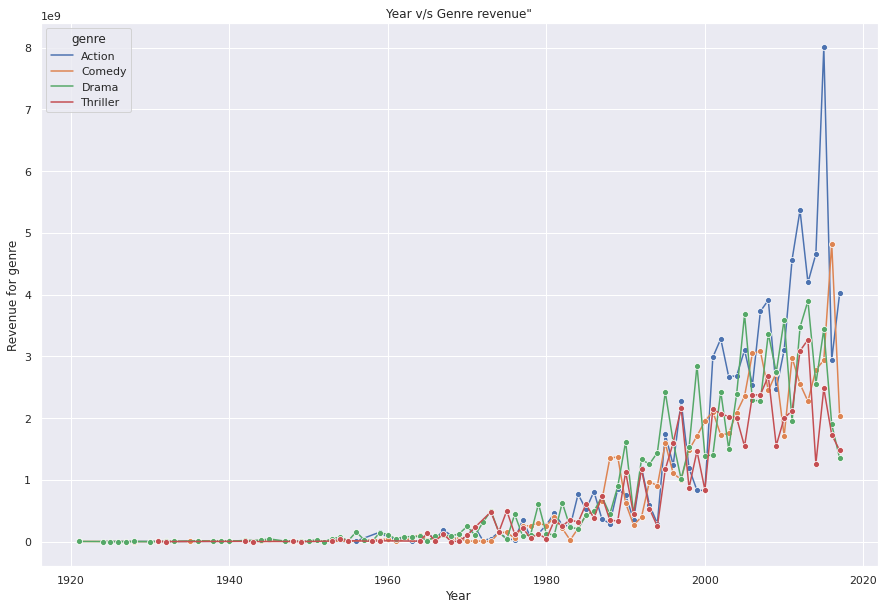

In [ ]:
plt.subplots(figsize=[15,10])
plot = sns.lineplot(x='year', y='revenue', hue='genre', data=top_genre_revenue, marker='o')
plot.set_title('Year v/s Genre revenue"');
plot.set(xlabel='Year', ylabel='Revenue for genre')
plt.show()

Here, we see that Action movies stand out in making more revenue even though there were more numer of drama movies being released in the 2000's.

# Part 7 - Pairwise Pearson Correlation

In [ ]:
train_df.columns

Index(['id', 'belongs_to_collection', 'budget', 'genres', 'imdb_id',
       'original_language', 'original_title', 'overview', 'popularity',
       'production_companies', 'production_countries', 'release_date',
       'runtime', 'spoken_languages', 'status', 'title', 'Keywords', 'cast',
       'crew', 'revenue', 'has_homepage', 'has_tagline', 'is_collection_part',
       'log_revenue', 'day_of_week', 'month', 'year', 'cast_count',
       'na_gender_cast_count', 'female_cast_count', 'male_cast_count',
       'freq_cast_power', 'avg_freq_cast_power', 'lead_freq_cast_power',
       'lead1_freq_cast_power', 'is_lead_male', 'rating', 'totalVotes',
       'log_budget', 'budget_to_cast', 'genres_count', 'prod_ctry_count',
       'prod_companies_count'],
      dtype='object')

## Heatmap/Correlation

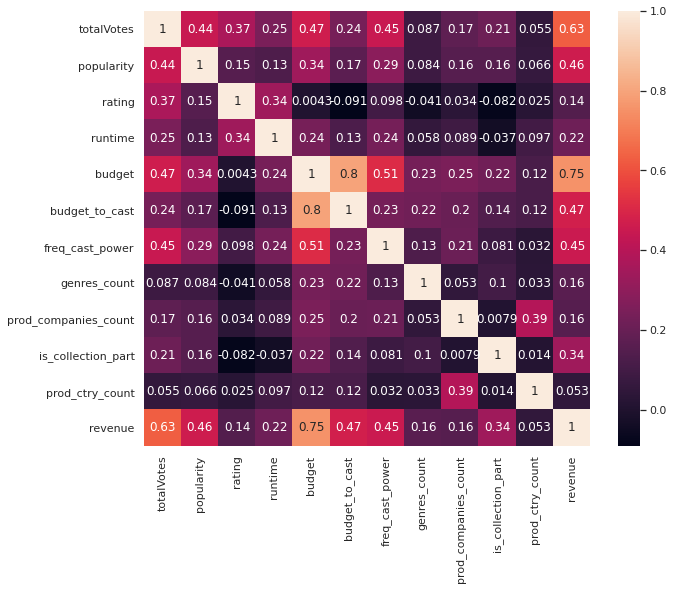

In [ ]:
heatmap1 = train_df[['totalVotes','popularity', 'rating', 'runtime', 'budget', 'budget_to_cast', 'freq_cast_power',
                     'genres_count', 'prod_companies_count', 'is_collection_part', 'prod_ctry_count', 'revenue']]
f,ax = plt.subplots(figsize=(10, 8))
sns.heatmap(heatmap1.corr(), annot=True)
plt.show()

I see that budget is the most relate to revenue with a whopping 0.75 coefficient. 
The budget is also very highly correlated to budget_to_cast ration (0.8) which is kind of obvious.

Production country count is the least correlated to revenue with a coefficient of 0.053. 
is_collection_part and prod_ctry_count seems to have the lease correlation of 0.014. 

I also see some negative correlations, albeit low -- like is_coolection_part and rating.

# Part 8 - Regression and Permutation Test

### Train/Val data split

I am holding out a dev (val) set from the Train set in order to evaluate my model on the held out data while I train on the remaining training data. 

In [ ]:
train, val = train_test_split(train_df, train_size=0.8)

In [ ]:
print("train data: ", train.shape)
print("val data: ", val.shape)

train data:  (2400, 43)
val data:  (600, 43)


## Defining required functions


Define permutation test to get rmse with permutations; 

Define p-value calculation

In [ ]:
def permutationRmse(model, X_train, Y_train, X_val, Y_val, n_perms):
  perm_rmse = []
  for i in range(0, n_perms):
    Y_perm = np.random.permutation(Y_train)
    # model = LinearRegression()
    model.fit(X_train, Y_perm)
    Y_val_pred = model.predict(X_val)
    perm_rmse.append(np.sqrt(metrics.mean_squared_error(Y_val, Y_val_pred)))
  return perm_rmse


def pvalue(perm_rmse, true_rmse, n_perms):
  perm_rmse = np.array(perm_rmse)
  pvalue = (np.sum(perm_rmse <= true_rmse) + 1) / (n_perms + 1) # 1. we are checking for <= because our metric is rmse
                                                                  # and lower the rmse, the better the performance
                                                                  # 2. The +1 in 
  return pvalue

def plotPermutationTest(true_rmse, perm_rmse, feature, n_bins):
  plt.subplots(figsize=[15,10])
  plt.hist(perm_rmse, n_bins, label='Permutation RMSE',
          edgecolor='black')
  ylim = plt.ylim()
  plt.plot(2 * [true_rmse], ylim, '--g', linewidth=3,
          label='Linear Reg RMSE'
          ' (pvalue %s)' % pval)

  plt.ylim(ylim)
  plt.legend()
  plt.xlabel('RMSE')
  plt.ylabel('Frequency')
  plt.title('Permutation Test for LR with {}'.format(feature) )
  plt.show()


## LR with Budget 

In [ ]:
X_train = train[['budget']]
X_val = val[['budget']]

Y_train = train['log_revenue']
Y_val = val['log_revenue']


In [ ]:
model = LinearRegression()
model.fit(X_train, Y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [ ]:
Y_train_pred = model.predict(X_train)
rmse = np.sqrt(metrics.mean_squared_error(Y_train, Y_train_pred))
print('Root Mean Squared Error for train:'+str(rmse))

Root Mean Squared Error for train:2.6205898281931335


In [ ]:
Y_val_pred = model.predict(X_val)

true_rmse = np.sqrt(metrics.mean_squared_error(Y_val, Y_val_pred))

print('Root Mean Squared Error for val:'+str(true_rmse))

Root Mean Squared Error for val:2.9385409689264534


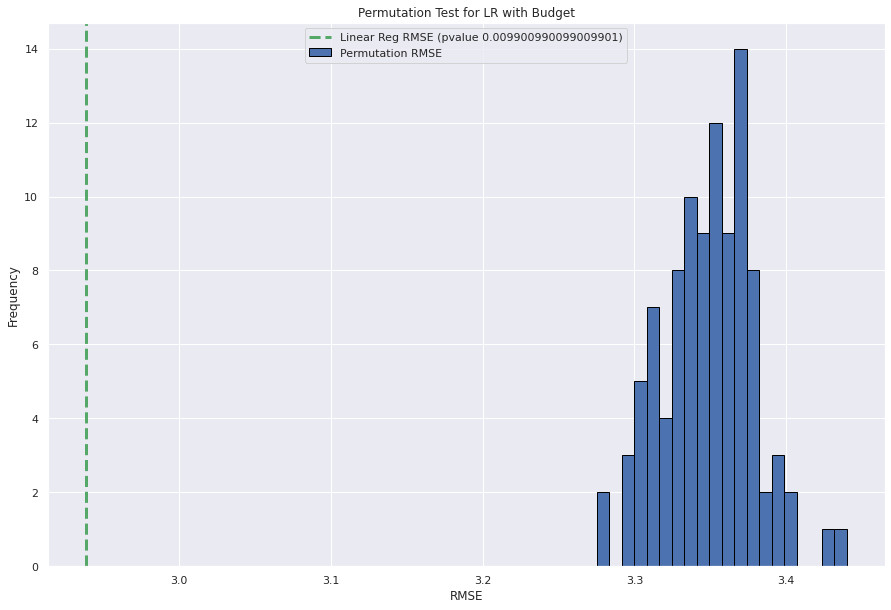

In [ ]:
n_perms = 100
perm_rmse = permutationRmse(model, X_train, Y_train, X_val, Y_val, n_perms)
pval = pvalue(perm_rmse, true_rmse, n_perms)
plotPermutationTest(true_rmse, perm_rmse, 'Budget', 20)

## LR with Total Votes 

In [ ]:
X_train = train[['totalVotes']]
X_val = val[['totalVotes']]

Y_train = train['log_revenue']
Y_val = val['log_revenue']


In [ ]:
model = LinearRegression()
model.fit(X_train, Y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [ ]:
Y_train_pred = model.predict(X_train)
rmse = np.sqrt(metrics.mean_squared_error(Y_train, Y_train_pred))
print('Root Mean Squared Error:'+str(rmse))

Root Mean Squared Error:2.7541997366406092


In [ ]:
Y_val_pred = model.predict(X_val)

true_rmse = np.sqrt(metrics.mean_squared_error(Y_val, Y_val_pred))

print('Root Mean Squared Error:'+str(true_rmse))

Root Mean Squared Error:3.067152423416418


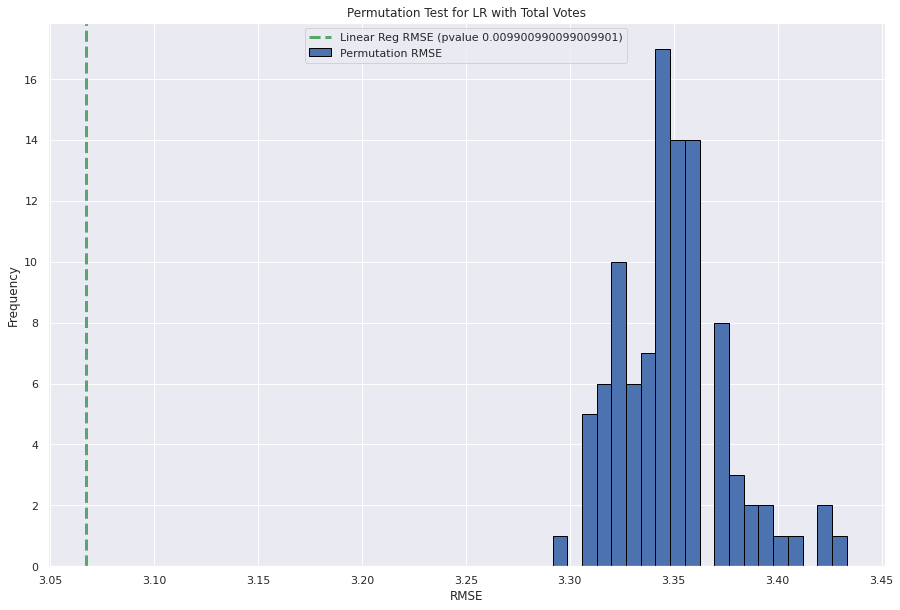

In [ ]:
n_perms = 100
perm_rmse = permutationRmse(model, X_train, Y_train, X_val, Y_val, n_perms)
pval = pvalue(perm_rmse, true_rmse, n_perms)
plotPermutationTest(true_rmse, perm_rmse, 'Total Votes', 20)

## LR with Year of Movie's Release

In [ ]:
train.columns

Index(['id', 'belongs_to_collection', 'budget', 'genres', 'imdb_id',
       'original_language', 'original_title', 'overview', 'popularity',
       'production_companies', 'production_countries', 'release_date',
       'runtime', 'spoken_languages', 'status', 'title', 'Keywords', 'cast',
       'crew', 'revenue', 'has_homepage', 'has_tagline', 'is_collection_part',
       'log_revenue', 'day_of_week', 'month', 'year', 'cast_count',
       'na_gender_cast_count', 'female_cast_count', 'male_cast_count',
       'freq_cast_power', 'avg_freq_cast_power', 'lead_freq_cast_power',
       'lead1_freq_cast_power', 'is_lead_male', 'rating', 'totalVotes',
       'log_budget', 'budget_to_cast', 'genres_count', 'prod_ctry_count',
       'prod_companies_count'],
      dtype='object')

In [ ]:
X_train = train[['year']]
X_val = val[['year']]

Y_train = train['log_revenue']
Y_val = val['log_revenue']


In [ ]:
model = LinearRegression()
model.fit(X_train, Y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [ ]:
Y_train_pred = model.predict(X_train)
rmse = np.sqrt(metrics.mean_squared_error(Y_train, Y_train_pred))
print('Root Mean Squared Error:'+str(rmse))

Root Mean Squared Error:2.995390377659548


In [ ]:
Y_val_pred = model.predict(X_val)

true_rmse = np.sqrt(metrics.mean_squared_error(Y_val, Y_val_pred))

print('Root Mean Squared Error:'+str(true_rmse))

Root Mean Squared Error:3.3503999940515485


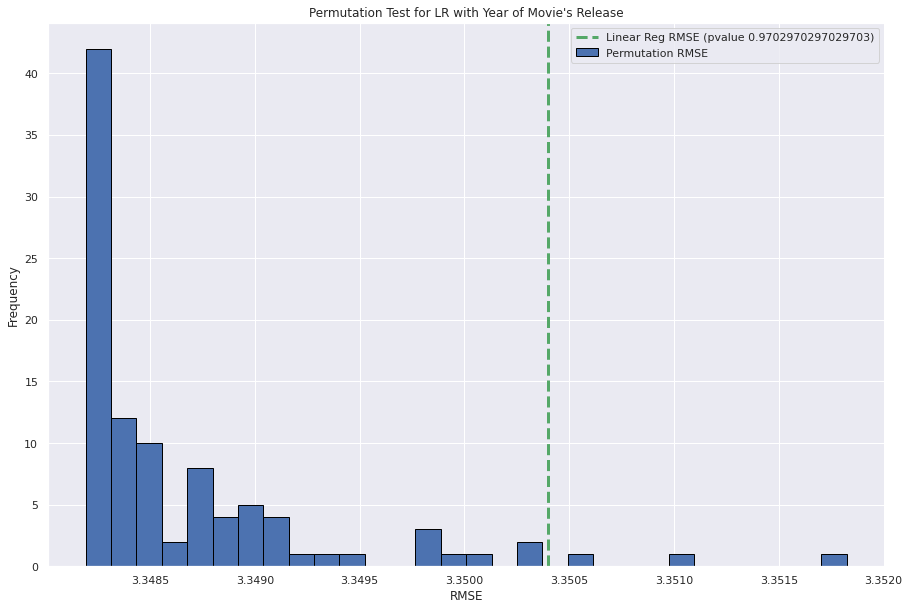

In [ ]:
n_perms = 100
perm_rmse = permutationRmse(model, X_train, Y_train, X_val, Y_val, n_perms)
pval = pvalue(perm_rmse, true_rmse, n_perms)
plotPermutationTest(true_rmse, perm_rmse, "Year of Movie's Release", 30)

## Observations 

Budget and TotalVotes seem to be good predicting variables since they have a p-value as low as 0.009
Year of release seem to be a bad predictor as it has a p-value as high as 0.97


# Part 9 - Prediction

## Sample Submission 

In [ ]:
sample_submission = pd.read_csv(parent_dir+'sample_submission.csv')

In [ ]:
sample_submission

id  revenue
0     3001  1000000
1     3002  1000000
2     3003  1000000
3     3004  1000000
4     3005  1000000
...    ...      ...
4393  7394  1000000
4394  7395  1000000
4395  7396  1000000
4396  7397  1000000
4397  7398  1000000

[4398 rows x 2 columns]

## Adding features

### Adding Frequency-Based Cast Power to the test data

1. Calculate actor-freq as the #movies an actor appears in.
2. For each movie, add up the actor-freq of each actor in the cast.

In [ ]:
test_cast_df = pd.concat([pd.DataFrame(x) for x in test_df['cast'] if x])

In [ ]:
test_cast_frequency = test_cast_df.groupby('id', as_index=False).agg({'name': 'last', 'cast_id': 'count'})
test_cast_frequency.rename(columns={'cast_id': 'actor_freq'}, inplace=True)

In [ ]:
def calculateTestFreqCastPower(cast):
  return sum([int(test_cast_frequency[test_cast_frequency.id == x['id']]['actor_freq']) for x in cast])


In [ ]:
test_df['freq_cast_power'] = test_df['cast'].apply(lambda x : calculateTestFreqCastPower(x))

##### Log-Budget

In [ ]:
test_df['log_budget'] = np.log(test_df['budget'] + 1)

##### Log-Votes

In [ ]:
test_df['log_votes'] = np.log(test_df['totalVotes'])
train_df['log_votes'] = np.log(train_df['totalVotes'])

#### Budget_year ratio

In [ ]:
train_df['budget_year_ratio'] = train_df['budget']/((train_df['year'] % 100) * (train_df['year'] % 100))
test_df['budget_year_ratio'] = test_df['budget']/((test_df['year'] % 100) * (test_df['year'] % 100))

In [ ]:
train_df['budget_year_ratio'].isnull().sum()

65

In [ ]:
train_df['budget_year_ratio'].fillna(0, inplace=True)

In [ ]:
test_df['budget_year_ratio'].isnull().sum()

90

In [ ]:
test_df['budget_year_ratio'].fillna(0, inplace=True)

## Train/Val data split

I am holding out a dev (val) set from the Train set in order to evaluate my model on the held out data while I train on the remaining training data. This will help me prevent overfitting in my model.

In [ ]:
train_data, val_data = train_test_split(train_df, train_size=0.9)
test_data = test_df


In [ ]:
print("train data: ", train_data.shape)
print("val data: ", val_data.shape)
print("test data: ", test_data.shape)

train data:  (2700, 45)
val data:  (300, 45)
test data:  (4398, 31)


In [ ]:
train_data.columns

Index(['id', 'belongs_to_collection', 'budget', 'genres', 'imdb_id',
       'original_language', 'original_title', 'overview', 'popularity',
       'production_companies', 'production_countries', 'release_date',
       'runtime', 'spoken_languages', 'status', 'title', 'Keywords', 'cast',
       'crew', 'revenue', 'has_homepage', 'has_tagline', 'is_collection_part',
       'log_revenue', 'day_of_week', 'month', 'year', 'cast_count',
       'na_gender_cast_count', 'female_cast_count', 'male_cast_count',
       'freq_cast_power', 'avg_freq_cast_power', 'lead_freq_cast_power',
       'lead1_freq_cast_power', 'is_lead_male', 'rating', 'totalVotes',
       'log_budget', 'budget_to_cast', 'genres_count', 'prod_ctry_count',
       'prod_companies_count', 'log_votes', 'budget_year_ratio'],
      dtype='object')

## Models

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler

### Linear Regression (Baseline)

1. Tried with and without normalizing features

2. Tried with various combinations of features

3. Tried adding new features

4. Initially, was predicting revenue 

5. Later, predicted log(revenue) and while submitting took the exponential of the predicted values.

##### Features and labels for Linear regression

In [ ]:
train_data.columns

Index(['id', 'belongs_to_collection', 'budget', 'genres', 'imdb_id',
       'original_language', 'original_title', 'overview', 'popularity',
       'production_companies', 'production_countries', 'release_date',
       'runtime', 'spoken_languages', 'status', 'title', 'Keywords', 'cast',
       'crew', 'revenue', 'has_homepage', 'has_tagline', 'is_collection_part',
       'log_revenue', 'day_of_week', 'month', 'year', 'cast_count',
       'na_gender_cast_count', 'female_cast_count', 'male_cast_count',
       'freq_cast_power', 'avg_freq_cast_power', 'lead_freq_cast_power',
       'lead1_freq_cast_power', 'is_lead_male', 'rating', 'totalVotes',
       'log_budget', 'budget_to_cast', 'genres_count', 'prod_ctry_count',
       'prod_companies_count', 'log_votes', 'budget_year_ratio'],
      dtype='object')

In [ ]:
# features = ['budget', 'totalVotes', 'popularity', 'freq_cast_power', ]. -- with revenue and log_revenue
# features = ['budget', 'totalVotes', 'popularity', 'runtime']. -- with revenue and log_revenue
# features = ['budget', 'totalVotes', 'runtime']  -- with log_revenue
# features = ['log_budget', 'totalVotes', 'runtime', 'popularity']. -- with log_revenue
# features = ['log_budget', 'totalVotes']. -- with log_revenue

In [ ]:
features = ['log_budget', 'totalVotes'] #, 'runtime', 'popularity']

X_train = train_data[features]
X_val = val_data[features]
X_test = test_data[features]

Y_train = train_data[['log_revenue']]
Y_val = val_data[['log_revenue']]


##### Normalizing features

In [ ]:
scaler = MinMaxScaler()
scaler.fit(X_train)

MinMaxScaler(copy=True, feature_range=(0, 1))

In [ ]:
X_train = scaler.transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

##### Model fitting and predictions

In [ ]:
model = LinearRegression()
model.fit(X_train, Y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [ ]:
Y_train_pred = model.predict(X_train)

mae = metrics.mean_absolute_error(Y_train, Y_train_pred)
msq = metrics.mean_squared_error(Y_train, Y_train_pred)
rmse = np.sqrt(metrics.mean_squared_error(Y_train, Y_train_pred))

print('Mean Absolute Error:'+str(mae))
print('Mean Squared Error:'+str(msq))
print('Root Mean Squared Error:'+str(rmse))

Mean Absolute Error:1.755835617339077
Mean Squared Error:6.413866226005236
Root Mean Squared Error:2.53256119886672


In [ ]:
Y_val_pred = model.predict(X_val)

mae = metrics.mean_absolute_error(Y_val, Y_val_pred)
msq = metrics.mean_squared_error(Y_val, Y_val_pred)
rmse = np.sqrt(metrics.mean_squared_error(Y_val, Y_val_pred))

print('Mean Absolute Error:'+str(mae))
print('Mean Squared Error:'+str(msq))
print('Root Mean Squared Error:'+str(rmse))

Mean Absolute Error:1.845399259730632
Mean Squared Error:7.045813678018913
Root Mean Squared Error:2.654395162371065


In [ ]:
Y_test_pred = model.predict(X_test)

##### Submission

In [ ]:
submission = pd.DataFrame()
submission['id'] = test_data['id']
submission['revenue'] = np.exp(Y_test_pred)
print(submission.shape)
submission.head()

(4398, 2)


id      revenue
0  3001   736558.366
1  3002  5283874.899
2  3003   814914.444
3  3004 22334688.393
4  3005  9122607.607

In [ ]:
submission.to_csv("submission.csv", index=False)

### Gradient Boosting Regressor (Best Model) and Random Forest Regressor

1. Tried with and without normalizing features

2. Tried with various combinations of features

3. Tried adding new features

4. Tried parameter tuning: played around with number of estimators, tree depth, learning rate and min_samples_split.

##### Features and labels for Linear regression

In [ ]:
train_data.columns

Index(['id', 'belongs_to_collection', 'budget', 'genres', 'imdb_id',
       'original_language', 'original_title', 'overview', 'popularity',
       'production_companies', 'production_countries', 'release_date',
       'runtime', 'spoken_languages', 'status', 'title', 'Keywords', 'cast',
       'crew', 'revenue', 'has_homepage', 'has_tagline', 'is_collection_part',
       'log_revenue', 'day_of_week', 'month', 'year', 'cast_count',
       'na_gender_cast_count', 'female_cast_count', 'male_cast_count',
       'freq_cast_power', 'avg_freq_cast_power', 'lead_freq_cast_power',
       'lead1_freq_cast_power', 'is_lead_male', 'rating', 'totalVotes',
       'log_budget', 'budget_to_cast', 'genres_count', 'prod_ctry_count',
       'prod_companies_count', 'log_votes', 'budget_year_ratio'],
      dtype='object')

In [ ]:
# features = ['log_budget', 'totalVotes']. -- with log_revenue
# features = ['log_budget', 'log_votes']. -- with log_revenue
# features = ['log_budget']. -- with log_revenue
# features = ['totalVotes']. -- with log_revenue
# features = ['log_budget', 'totalVotes', 'freq_cast_power']
# features = ['budget', 'totalVotes', 'freq_cast_power']
# features = ['log_budget', 'totalVotes', 'freq_cast_power', 'budget_year_ratio']
# features = ['log_budget', 'log_votes', 'freq_cast_power', 'budget_year_ratio']
# features = ['log_budget', 'log_votes', 'budget_year_ratio']
# features = ['log_budget', 'log_votes', 'freq_cast_power', 'budget_year_ratio', 'is_collection_part', 'popularity']
# features = ['log_budget', 'log_votes', 'freq_cast_power', 'budget_year_ratio', 'is_collection_part', 'runtime', 'totalVotes']
# features = ['log_budget', 'log_votes', 'freq_cast_power', 'budget_year_ratio', 'is_collection_part']

In [ ]:
features = ['log_budget', 'log_votes', 'freq_cast_power', 'budget_year_ratio', 'is_collection_part', 'runtime'] #-- Best Model

X_train = train_data[features]
X_val = val_data[features]
X_test = test_data[features]

Y_train = train_data[['log_revenue']]
Y_val = val_data[['log_revenue']]


##### Normalizing features

In [ ]:
# scaler = MinMaxScaler()
# scaler.fit(X_train)

In [ ]:
# X_train = scaler.transform(X_train)
# X_val = scaler.transform(X_val)
# X_test = scaler.transform(X_test)

##### Model fitting and predictions

In [ ]:
# params = {'n_estimators': 500,
#           'max_depth': 4,
#           'min_samples_split': 5
#           }
# model = rfr(**params)
# model.fit(X_train, Y_train)

In [ ]:
params = {'n_estimators': 500,
          'max_depth': 4,
          'min_samples_split': 5,
          'learning_rate': 0.01,
          'loss': 'ls'}
          
model = gdr(**params)
model.fit(X_train, Y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.01, loss='ls', max_depth=4,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=5,
                          min_weight_fraction_leaf=0.0, n_estimators=500,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [ ]:
Y_train_pred = model.predict(X_train)

mae = metrics.mean_absolute_error(Y_train, Y_train_pred)
msq = metrics.mean_squared_error(Y_train, Y_train_pred)
rmse = np.sqrt(metrics.mean_squared_error(Y_train, Y_train_pred))

print('Mean Absolute Error:'+str(mae))
print('Mean Squared Error:'+str(msq))
print('Root Mean Squared Error:'+str(rmse))

Mean Absolute Error:1.2113482333046766
Mean Squared Error:3.3967434455574637
Root Mean Squared Error:1.84302562259928


In [ ]:
Y_val_pred = model.predict(X_val)

mae = metrics.mean_absolute_error(Y_val, Y_val_pred)
msq = metrics.mean_squared_error(Y_val, Y_val_pred)
rmse = np.sqrt(metrics.mean_squared_error(Y_val, Y_val_pred))

print('Mean Absolute Error:'+str(mae))
print('Mean Squared Error:'+str(msq))
print('Root Mean Squared Error:'+str(rmse))

Mean Absolute Error:1.3994619911707313
Mean Squared Error:4.274052758782034
Root Mean Squared Error:2.0673782331208854


In [ ]:
Y_test_pred = model.predict(X_test)

##### Submission

In [ ]:
submission = pd.DataFrame()
submission['id'] = test_data['id']
submission['revenue'] = np.exp(Y_test_pred)
print(submission.shape)
submission.head()

(4398, 2)


id      revenue
0  3001   771641.623
1  3002   461046.296
2  3003  1981364.644
3  3004 28067155.531
4  3005   601365.513

In [ ]:
submission.to_csv("submission.csv", index=False)

## Additional Details

I found that a train/test split of 90/10 with the gradient boosting regressor model and the selected features above gave me the least rmse and best predictions. 

Predicting the log_revenue and then exponentiating the results helped my model by multiple folds. 

I have commented features above in both baseline and final models that I tried.

I started with a score of ~7.59 and jumped to ~2.09 as my best score with multiple submissions.

I also borrowed the idea of budget_year_ratio from a notebook available online (have it in references)

# Part 10 - Final Result

Report your highest score. Include a snapshot of your best score after submission as confirmation. Be sure to provide a link to your Kaggle profile. Make sure your profile includes your face and affiliation with SBU.

Kaggle Link: https://www.kaggle.com/niksoni

Highest Score: 2.09254

Number of entries: 15

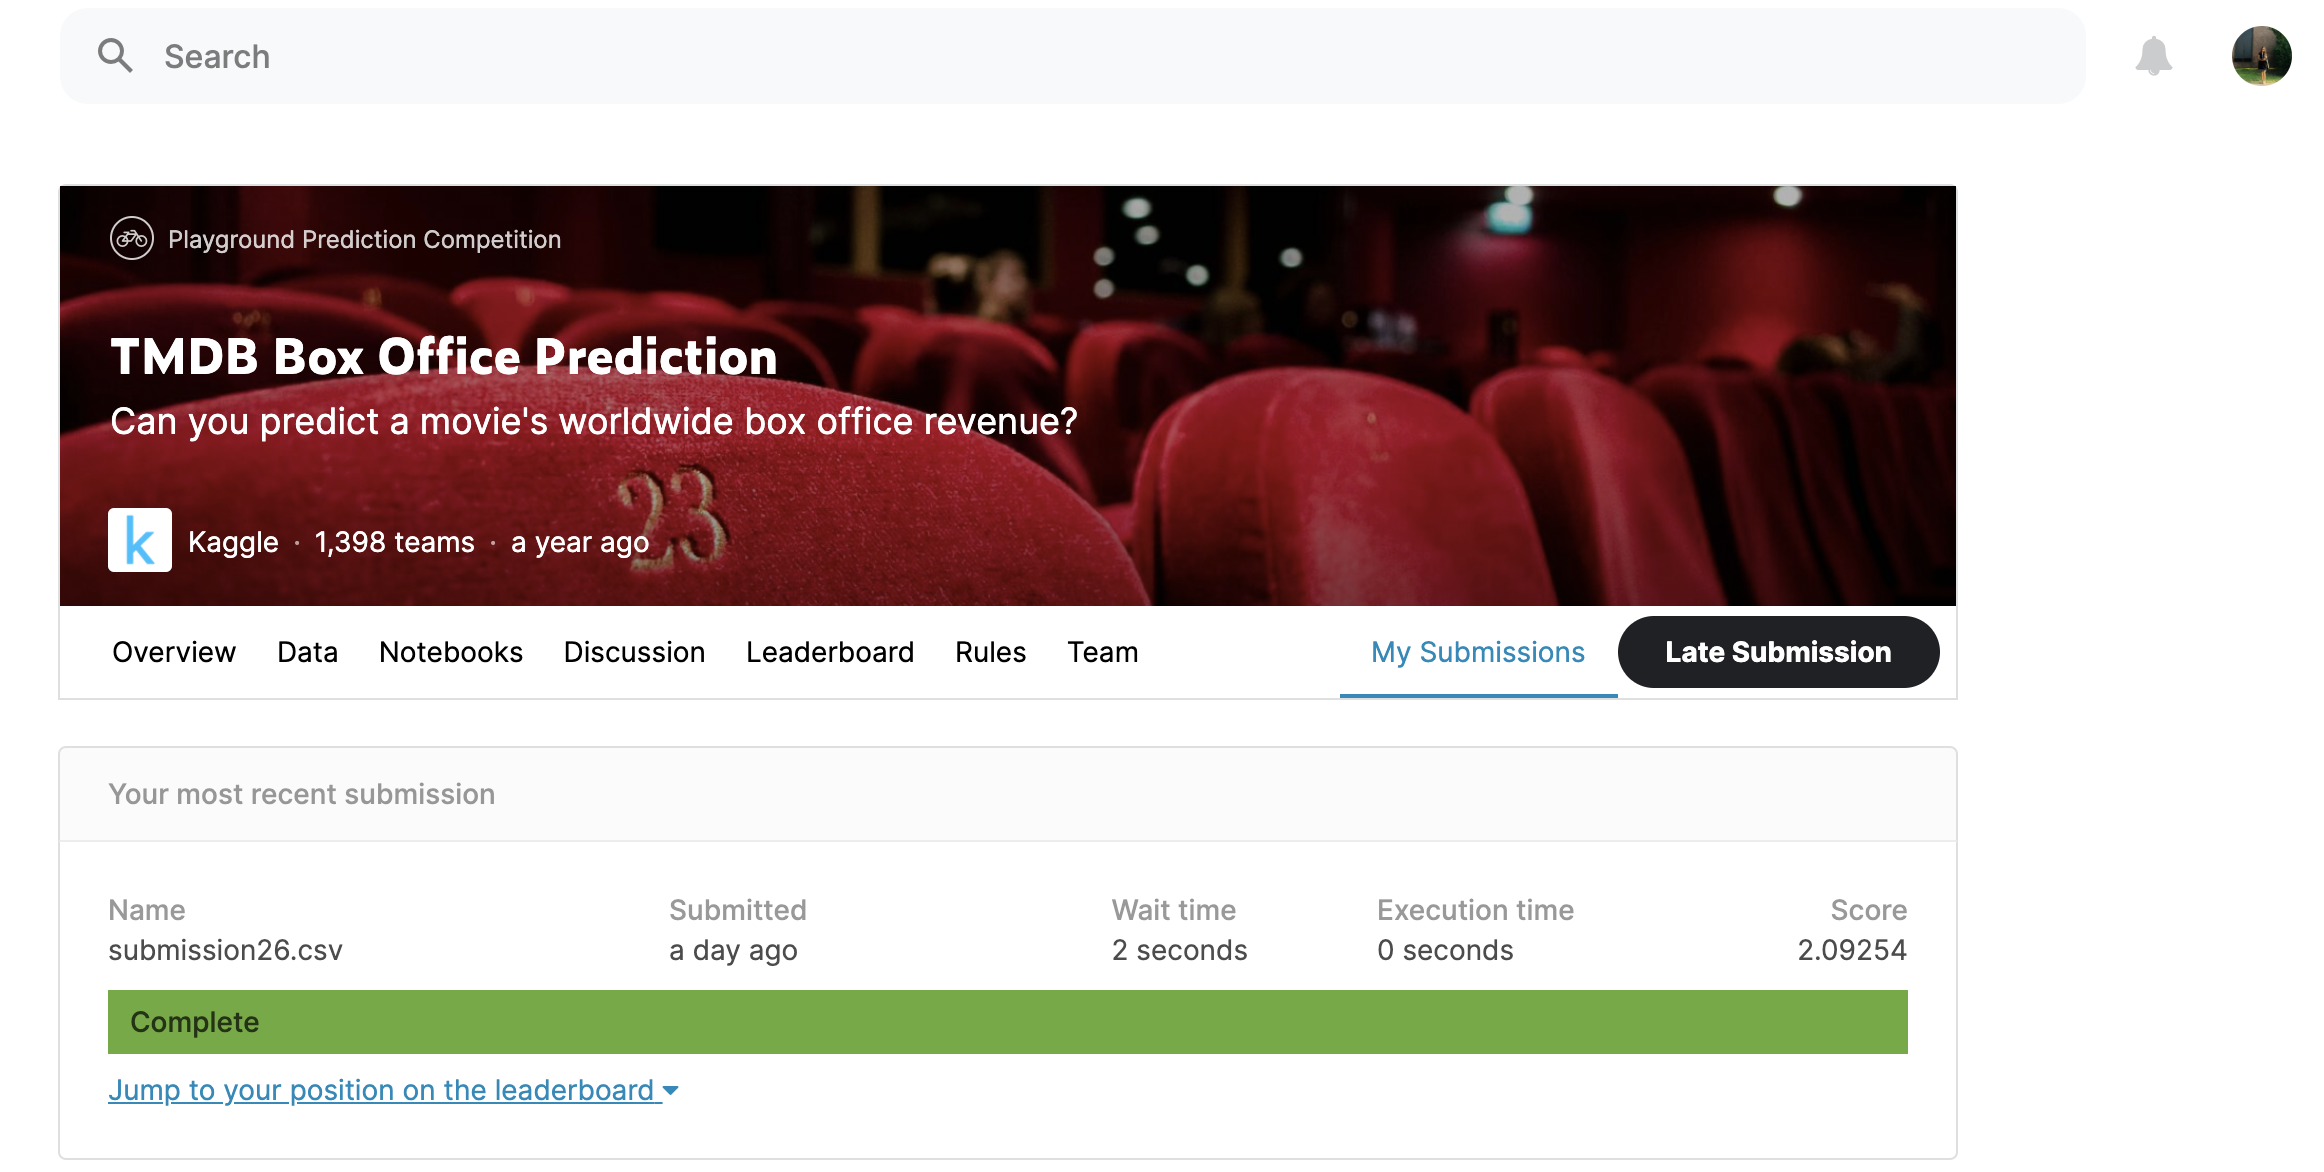

# References

https://www.kaggle.com/takedown/tmdb-box-office-revenue-prediction -- only for budget_year_ratio idea.

